# Spectral Methods Part II: Chapters 4

Ernesto Barraza-Valdez, June 24, 2024

This notebook follows *Implementing Spectral Methods for Partial Differential Equations* by Dr. David Kopriva.

This is the second of several notebooks that covers Chapters 4 of Dr. Kopriva's textbook.

In this notebook, you are expected to know some Julia and to follow along the book. 
Because Julia has many useful libraries and packages for linear algebra (such as BLAS) and fourier transforms (such as FFTW) we will put those to use in order to focus more on advanced methods for non-periodic problems. 

In [1]:
#Check if Julia is working by checking version
VERSION

v"1.10.3"

We will activate a project in order to keep all Julia Packages useful for the rest of the notebooks

In [2]:
] activate .

  Activating project at `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods`


If you haven't already created the project from the previous notebook uncomment the next code cell and run it. If the project is already created then you can leave it commented

In [3]:
# ] add BenchmarkTools FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia Revise

In [4]:
using FFTW
using Base.Threads
using LinearAlgebra
using SparseArrays
using Test
using TimerOutputs
using HDF5
using Printf
using FastGaussQuadrature
using ApproxFun
using FastTransforms
using FastChebInterp
using Polynomials
using SpecialPolynomials
using BenchmarkTools
using Latexify
using Plots
using LaTeXStrings
using IncompleteLU
using Preconditioners 
using IterativeSolvers
using LinearMaps
using RecursiveFactorization
using LinearOperators
using Krylov
using IJulia
using Revise

# Creating a Julia Package

We need to create a package in Julia to store all our functions from Chapters 1-3. 

We can follow the following links for `Pkg.jl`: 

https://pkgdocs.julialang.org/v1/creating-packages/

and `Revise.jl`

https://timholy.github.io/Revise.jl/stable/

Where `Revise.jl` makes it easy to revise any of the source code of the package.

First we generate a package with the base package of `Pkg.jl`

Notice that in Jupyter we can use the bracket `]` to access `Pkg` mode

If you have not done this, go ahead and uncomment the below cell

In [5]:
# ] generate Part1

A Part I directory was added. Navigating through it we can access the src directory where we will put the Chapter 1-3 code

Next we need to use a terminal app and open Julia. Navigate to this folder.

Activate a project there and add the packages needed for Chapters 1-3. 

Such as the following steps:

```
$> cd ./Part1
$> julia
```

then in Julia

```
] activate .
```
```
] add BenchmarkTools LinearAlgebra SparseArrays FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia
```

After we paste our code from the previous notebook. 

After doing the above we can import the Part1 package. First we need to add it to the scope

In [6]:
push!(LOAD_PATH, "Part1/");


Then we just use the `using`

In [7]:
using Part1

Part 1 functions are now fully loaded

# Ch 4: Survey of Spectral Approximations
---

# 4.1 Fourier Colocation Method

Advection-Diffusion Equation

\begin{align}
\partial_t \phi + \partial_x \phi &= \nu \partial_{xx} \phi \:\:\:, \:\:\:\:\: 0\lt x \lt 2\pi \:\:,\:\: t\gt 0 \\
\phi(x,0) &= \phi_0(x) \:\:\:, \:\:\:\:\: 0\lt x \lt 2\pi \\
\phi(0,t) &= \phi(2\pi,t)  \:\:\:, \:\:\:\:\: t\gt 0
\end{align}

Assum $\nu >0$

In [8]:
#Ch 4.1.1 pg 97
#algorithm 41 
#The Fourier Collocation Time Derivative for the Advection-Diffusion Equation
function FourierCollocationTimeDerivative(Phi::Array{Float64}, D::Matrix{Float64}, nu::Float64)

    F = D*Phi
    @. F = nu*F - Phi
    F = D*F #Dphi
    return F


end

FourierCollocationTimeDerivative (generic function with 1 method)

In [9]:
#Ch 4.1.1 pg 98
#alg 42
#Low storage Ruge-Kutta Integration of the Fourier Collocation Approximation
function CollocationStepByRK3!(tn::Float64, dt::Float64, Phi::Array{Float64}, D::Matrix{Float64}, nu::Float64)

    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    N = length(Phi)
    #Phij = copy(Phi)
    DPhi = zeros(Float64, size(Phi))
    G = zeros(Float64, size(Phi))

    for m in 1:3
        t = tn +bm[m]*dt
        DPhi = FourierCollocationTimeDerivative(Phi, D, nu)
        @. G = am[m]*G + DPhi
        @. Phi = Phi + gm[m] *dt *G
        
        # for j in 1:N
        #     G[j] = am[m]*G[j] + DPhi[j]
        #     Phi[j] = Phi[j] + gm[m] *dt *G[j]
        # end

    end

    return nothing

end

CollocationStepByRK3! (generic function with 1 method)

In [10]:
#Ch 4.1.1 pg 99
#alg 43 
#Driver for the Fourier Collocation Driver
function FourierCollocationDriver!(Phi::Array{Float64}, NT::Int64, Ttot::Float64, nu::Float64)

    dt = Ttot/NT
    tn = 0.0
    D = FourierDerivativeMatrix(length(Phi))
    #D = copy(transpose(D))
    for n in 1:(NT)
        
        CollocationStepByRK3!(tn, dt, Phi, D, nu)
        tn = (n)*dt
        
        
    end
    return nothing

end

FourierCollocationDriver! (generic function with 1 method)

### Benchmarking

Use the initial approximation which has **aliasing**:

\begin{align}
\Phi_j(0) = \phi_0(x_j)
\end{align}

Which is the same as using the initial values as interpolated points from function:

\begin{align}
\Phi(x,0) = I_N\phi_0
\end{align}

This interpolation of the initial values comes with aliasing errors. 

A better initial value approximation is using series truncation:

\begin{align}
\Phi_j(0) \Rightarrow \Phi(x,0)  = P_{N-1} \phi_0
\end{align}

Which is free of aliasing errors.



For the Fourier Collocation method we will use the Fourier Polynomials so our function will be approximated as: 

\begin{align}
    \varphi(x,t) \approx \Phi(x,t) = \sum_{n=0}^{N-1} \Phi_n(t) h_n(x)
\tag{4.14}
\end{align}

Where

\begin{align}
    h_n(x) = e^{i \; 2\pi \: n \; x} 
\end{align}


is the Fourier polynomial and $\Phi_n(t)$ is the coefficient. 

We can use the `FFT.fft()` function to obtain the coefficients 

In this example we use

$$
\nu = 0.2
$$

And a total number of points of $N_{total}= N+1 = 17$ from $x \in \left[ 0,2\pi\right]$ and a time step of $dt = 1.0e-5$

The initial function at time $t=0$:

\begin{align}
    \varphi(x,t=0) = \frac{3}{5 - 4 \: cos(x)}
\tag{4.26}
\end{align}

In [11]:
#non-aliased
NN = 16
nu = 0.2
dx = 2.0*pi /NN
dt = 1.0e-5
xxx = [i for i in 0:15].*dx
#aliased initial conditions
phi = @. 3/(5 - 4.0*cos(xxx));
phift = 1.0/NN * FFTW.fft(phi);
#obtain the wavenumbers 
#first we create an array from -(N+1)/2 to (N+1)/2
kxa = [i for i in floor(-NN/2):floor(NN/2-1)]
#then we fft shift in order to match the actual fft
kx = FFTW.fftshift(kxa)#FFTW.fftfreq(NN)#, 1/dx)
ekx = @. exp( kx *1.0im *xxx')
phi0 = real([sum(ekx[i,:].* phift) for i in 1:NN ])#copy(phi);
phi1 = copy(phi0)
phi2 = copy(phi0);

Let's check that our Fourier Coefficients match those of:

\begin{align}
    \hat{\varphi}_{0,k} = 2^{- \lvert k \rvert}
\end{align}

In [12]:
hatphi0 = 2.0.^(-1.0*abs.(kx)); 


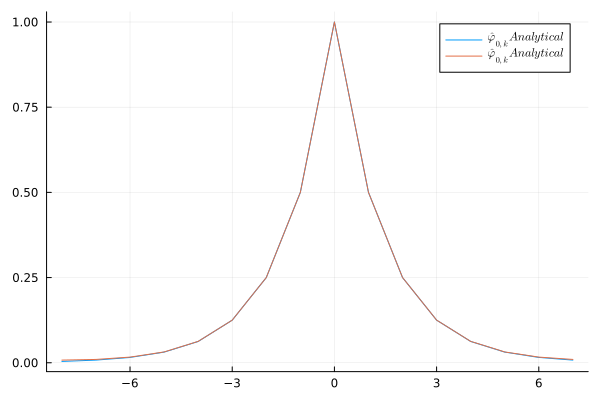

In [13]:
plot(FFTW.fftshift(kx), FFTW.fftshift(hatphi0), label=L"\hat{\varphi}_{0,k} Analytical", fmt = :png)
plot!(FFTW.fftshift(kx), FFTW.fftshift(real.(phift)), label=L"\hat{\varphi}_{0,k} Analytical", fmt = :png)


Looks good and right on the money!

Run the Driver on the first `phi1` up to 1 second

In [14]:
#calculate total number of time steps
Nttot = ceil(Int64,1.0/dt)

100000

In [15]:
FourierCollocationDriver!(phi1, Nttot, 1.0, nu)

Run the Driver on the second `phi2` up to 2 seconds

In [16]:
Nttot = ceil(Int64,2.0/dt)

200000

In [17]:
FourierCollocationDriver!(phi2, Nttot, 2.0, nu)

Let's plot the results

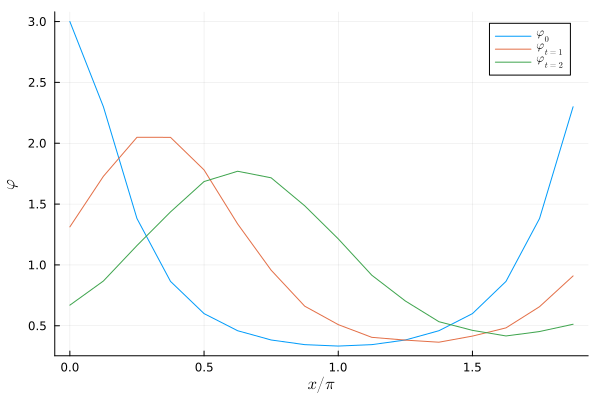

In [18]:
plot(xxx./pi, phi0, label=L"\varphi_{0}", fmt = :png)
plot!(xxx./pi, phi1, label=L"\varphi_{t=1}", fmt = :png)
plot!(xxx./pi, phi2, label=L"\varphi_{t=2}", fmt = :png)
ylabel!(L"\varphi")
xlabel!(L"x/\pi")

Which is exactly **Figure 4.2** on page 100.0

# 4.2: Fourier Galerkin Method

\begin{align}
(\varphi_t, \phi) + (\varphi_x, \phi) = \nu \varphi_x \left. \phi \right|^{2\pi}_{0} - (\nu \varphi_x, \phi_x)
\tag{4.34}
\end{align}

We approximate the solution by a fourier polynomial of degree N:

\begin{align}
\varphi(x,t) \approx \Phi(x,t) = \sum^{N/2}_{n=-N/2} \hat{\Phi}_n(t) e^{inx}
\tag{4.35}
\end{align}

There are $N+1$ degrees of freedom to find

Because the boundaries are periodic:

\begin{align}
\left. \phi \right|^{2\pi}_{0} \Rightarrow 0
\end{align}

and using the fourier basis of $N+1$:

\begin{align}
\phi(x) = e^{i k x} \:\:\:, \:\:\: k = -N/2 .... N/2
\end{align}

Because of the orthoganality:

\begin{align}
\partial_t \hat{\Phi}_k(t) = -\left( i k + k^2  \right)\hat{\Phi}_k(t)
\tag{4.39}
\end{align}

We then only need the initial conditions which we approximate with truncation:

\begin{align}
\Phi(x,0) = P_N \phi_0
\end{align}

and thus:

\begin{align}
\hat{\Phi}_k(0) = \hat{\phi}_{0,k}
\tag{4.40}
\end{align}

In [19]:
#Ch 4.2.1 pg 103 
#alg 44
#Advection Diffusion Time Derivative for Fourier Galerkin
function AdvectionDiffusionTimeDerivative!(Phi::Array{ComplexF64}, DPhi::Array{ComplexF64}, k::Array{Float64}, nu::Float64)

    @. DPhi = -(1.0im * k + nu*k^2) * Phi
    return nothing

end

AdvectionDiffusionTimeDerivative! (generic function with 1 method)

In [20]:
#alg 45
#Ch 4.2.1 pg 104
#Take one time step of Fourier Galerkin Method using RK3
function FourierGalerkinStep!(Phi::Array{ComplexF64},DPhi::Array{ComplexF64},k::Array{Float64},nu::Float64, tn::Float64, dt::Float64)
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    #t = 0.0
    N = length(Phi)
    G = zeros(ComplexF64, size(Phi))
    for m in 1:3
        t = tn + bm[m]*dt
        AdvectionDiffusionTimeDerivative!(Phi, DPhi, k, nu)
        @. G = am[m] * G + DPhi
        @. Phi = Phi + gm[m]*dt*G
    end

end

FourierGalerkinStep! (generic function with 1 method)

In [21]:
#alg 46
#Ch 4.2.1 pg 104
#Direct Synthesis of Fourier Galerkin Solution
function EvaluateFourierGalerkinSolution!(Phi::Array{ComplexF64},Phik::Array{ComplexF64},k::Array{Float64}, x::Array{Float64})

    No = length(x)
    phi = zeros(ComplexF64, size(Phik))
    for j in 1:No
        @. phi = Phik*exp(1.0im * k * x[j])
        Phi[j] = sum(phi)
    end

    return nothing

    

end

EvaluateFourierGalerkinSolution! (generic function with 1 method)

In [22]:
#alg 47
#Ch 4.2.1 pg 105
#Driver for Fourier Galerkin 
function FourierGalerkinDriver!(Phi::Array{ComplexF64},Phiout::Array{ComplexF64}, NT::Int64, Ttot::Float64, nu::Float64, Nout::Int64,planf)

    dt = Ttot/NT
    tn = 0.0
    N = length(Phi)
    Phik = planf*Phi
    Phik = 1.0/N * ( FFTW.fftshift(Phik))
    DPhi = zeros(ComplexF64, size(Phik))
    
    k = [j for j in -N/2.0:(N-1)/2.0]
    #dx0 = (2.0*pi)/N
    #k = Array(FFTW.fftfreq(N,1/dx0))
    #Phiout = zeros(ComplexF64, Nout)
    dx = 2.0*pi/Nout
    x = [j for j in 0.0:dx:2.0*pi]

    for n in 0:NT-1
        FourierGalerkinStep!(Phik,DPhi,k,nu, tn, dt)
        tn = (n+1)*dt
    end
    EvaluateFourierGalerkinSolution!(Phiout,Phik,k, x)
    

end

FourierGalerkinDriver! (generic function with 1 method)

### 4.2.2 Benchmark

We'll use the same function as **Eqn 4.26**.

This time we'll use FFTW plans.

In [23]:
#non-aliased
NN = 16
nu = 0.2
dx = 2.0*pi /NN

xxx = [i for i in 0:15].*dx
#aliased initial conditions
phi0 = @. 3/(5 - 4.0*cos(xxx));
phi0 = convert(Vector{ComplexF64}, phi0)
#phift = 1.0/NN * FFTW.fft(phi);
# ff = FFTW.fftshift([i for i in floor(-N/2):floor(N/2-1)])#FFTW.fftfreq(NN)#, 1/dx)
# ekx = @. exp( ff *1.0im *xxx')
#phi0 = real([sum(ekx[i,:].* phift) for i in 1:NN ])#copy(phi);
phi1 = copy(phi0)
phi2 = copy(phi0);
pf = FFTW.plan_fft(phi2, flags=FFTW.MEASURE);
phi2 = copy(phi0);

In [24]:
ttot = 1.0
dt = 1.0e-4
Nttot = ceil(Int64,ttot/dt)
Nout = 50
phiout1 = zeros(ComplexF64, Nout);
phiout2 = zeros(ComplexF64, Nout);
xout = [j for j in 0:Nout-1] .* (2.0*pi/Nout);

In [25]:
Nttot

10000

In [26]:
FourierGalerkinDriver!(phi1, phiout1,Nttot, 1.0, nu, Nout,pf)

In [27]:
FourierGalerkinDriver!(phi2, phiout2,Nttot, 2.0, nu, Nout,pf)

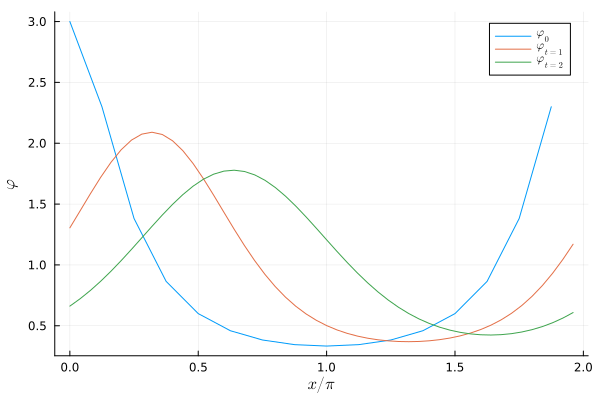

In [28]:
plot(xxx./pi, real.(phi0), label=L"\varphi_{0}", fmt = :png)
plot!(xout./pi, real.(phiout1), label=L"\varphi_{t=1}", fmt = :png)
plot!(xout./pi, real.(phiout2), label=L"\varphi_{t=2}", fmt = :png)
ylabel!(L"\varphi")
xlabel!(L"x/\pi")

# 4.3 Nonlinear and Product Terms

This section we'll just provide an overview of the code and not actually try any examples

Burger's Equation

\begin{align}
u_t + u u_x = \nu u_{xx}
\tag{4.41}
\end{align}

We will study when $\nu = 0$

In [29]:
# Algorithm 48: DirectConvolutionSum: Direct (Slow) Computation of the Convolution Sum

In [30]:
#alg 49
function FastConvolutionSum!(Q::Matrix{ComplexF64}, V::Matrix{ComplexF64}, W::Matrix{ComplexF64}, N::Int64, planf, planb)

    M = 2*N
    #initialize vectors
    Vkpad = zeros(ComplexF64,M)
    Wkpad = zeros(ComplexF64,M)
    Vx = zeros(ComplexF64,M)
    Wx = zeros(ComplexF64,M)
    Qx = zeros(ComplexF64,M)
    Qkpad = zeros(ComplexF64,M)

    for i in 1:N
        Vx[N + i] = V[i]
        Wx[N + i] = W[i]
    end 

    FFTW.ifftshift!(Vkpad,Vx)
    FFTW.ifftshift!(Wkpad, Wx)

    Vx = planb*Vkpad
    Wx = planb*Wkpad

    @. Qx = Vx*Wx
    Qkpad = planf*Qx
    FFTW.fftshift!(Qx,Qkpad)

    for i in 1:N
        Q[i] = Qx[N + i]
    end 

    return nothing
    

end

FastConvolutionSum! (generic function with 1 method)

# 4.4 Polynoial Collocation Methods

## 4.4.1 Approximation of the Diffusion Equation

Diffusion Equation

\begin{align}
\partial_t \varphi &=  \partial_{xx} \varphi \:\:\:, \:\:\:\:\: -1\lt x \lt 1 \:\:, \\
\varphi(x,0) &= \varphi_0(x) \:\:\:, \:\:\:\:\: -1\lt x \lt 1 \\
\varphi(-1,t) &= \varphi(1,t) =0
\tag{4.77}
\end{align}

Assum $\nu >0$

We approximate the solution $\varphi$ by a polynomial interpolant

\begin{align}
\varphi(x,t) \approx \Phi(x,t) = \sum_{n=0}^{N} \tilde{\Phi}_n(t)\phi_n(x) = \sum_{j=0}^{N} \tilde{\Phi}_j(t) l_j(x) 
\tag{4.78}
\end{align}

where the interpolation points, $x_j$ , are now the nodes of the Gauss-Lobatto quadrature. The collocation method is nodal, with the fundamental unknowns taken 
to be the$\Phi_j$j ’s, so we will use the second, Lagrange, representation fo the polynomiall

Next, we substitute the approximate solution, $\Phi$, into the PDE and require that
it satisfy the equation at the nodes. This requirement generates the system of ODEs
for the nodal values of the solution

\begin{align}
\left. \partial_t \Phi \right|_{x_j} - \left. \partial_{xx} \Phi \right|_{x_j}  = 0 \:\:\:,\:\:\:\:\:\: j = 1, 2, ..., N-1
\tag{4.79}
\end{align}

We use the boundary conditions to set the values at the end points: $\Phi_0 = \Phi_N = 0$

When we substitute for $\Phi$ with its nodal representation,

\begin{align}
\sum_{i=0}^{N} \partial_t \Phi_i l_i(x_j) - \sum_{i=0}^{N} \Phi_i  \partial_{xx} l_i(x_j)   = 0 \:\:\:,\:\:\:\:\:\: j = 1, 2, ..., N-1
\tag{4.80}
\end{align}

We can simplify the system of ODEs because $l_i(x_j) = \delta_{i,j}$. With the simplification,
the system of equations that we integrate in time become:

\begin{align}
\partial_t \Phi_j &= \sum_{i=0}^{N} \partial_{xx} l_i(x_j) = D^{(2)} \Phi_j\:\:\:, \:\:\:\:\: j = 1,2,...,N-1 \:\:, \\
\Phi_0 &= \Phi_N = 0
\tag{4.77}
\end{align}
s

### 4.4.2: How to Implement

In [31]:
#Alg 50
#Ch 4.4.1 pg 116
# Low Storage Runge-Kutta Integration of a Polynomial Collocation Approximation
#Note that I changed the name because similar to previous function
function DiffCollocationStepByRK3!(tn::Float64, dt::Float64, Phi::Array{Float64}, D2::Matrix{Float64}, nu::Float64)

    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    N = length(Phi)
    #Phij = copy(Phi)
    DPhi = zeros(Float64, size(Phi))
    G = zeros(Float64, size(Phi))

    for m in 1:3
        t = tn +bm[m]*dt
        #time derivative
        DPhi = D2*Phi
        @. G = am[m]*G + DPhi
        @. Phi = Phi + gm[m] *dt *G
        

    end
    #dirichlet boundary conditions
    Phi[1] = 0.0
    Phi[end] = 0.0

    return nothing

end

DiffCollocationStepByRK3! (generic function with 1 method)

In [32]:
#alg 51
#Ch 4.4.2 pg 118
# Drivers for Legendre Collocation Method
function LegendreCollocation!(Phi::Array{Float64},x::Array{Float64}, w::Array{Float64}, NT::Int64, Ttot::Float64, nu::Float64, Nout::Int64)

    dt = Ttot/NT
    tn = 0.0
    D2 = mthOrderPolynomialDerivativeMatrix(2, x)

    for n in 0:NT-1

        DiffCollocationStepByRK3!(tn, dt, Phi, D2, nu)
        tn = (n+1)*dt
        
    end

    X = [-1+2*j/Nout for j in 0:Nout]
    ww = BarycentricWeights(x)
    T = PolynomialInterpolationMatrix(x,X, ww,1.0e-9)
    Phiout = T*Phi

    return X, Phiout
    
end

LegendreCollocation! (generic function with 1 method)

### 4.4.3 Benchmarking

We will benchmark with:

\begin{align}
\varphi(x,t) = sin\left[ \pi \left( x+1 \right) \right] e^{-k^2 \pi^2 t}
\tag{4.82}
\end{align}

which satisfies the boundary conditions.

In this example $x \in \left[ -1, 1 \right]$ with $dx = 1/100$. Choose $k=1$ for simplicit and $N_{total} = N+1 = 13$. We want to approximate the solution with a finer amount of points of 24

In [48]:
#exact analytic solution
xana = [i for i in -1.0:2.0/200.0:1.0]
kana = 1.0
tana = 0.00
#make original for plotting at t=0.00
phiana0 = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);
# now at t=0.1
tana = 0.1
phiana = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);

In [49]:
#calculate Gauss Lobatto Nodes and Weights for Legendre Polynomials
nn = 12
xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 1000, 1.0e-8);

In [50]:
kk = 1.0
t0 = 0.0
#Now phi at t=0
phi0 = @. sin(pi*(xleg+1))*exp(-kk^2 * pi^2 *t0);


In [51]:
nout = 24
ttot = 0.1
nt = 500
nu = 0.2;
phi1 = deepcopy(phi0);

In [52]:
xxx, phiout = LegendreCollocation!(phi1,xleg, wleg, nt, ttot, nu, nout);


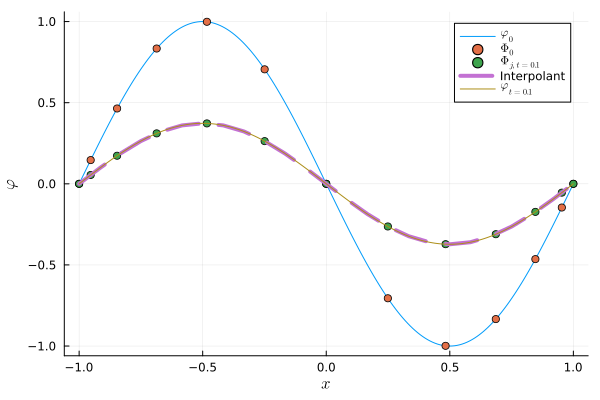

In [53]:
plot(xana, phiana0,label=L"\varphi_0",fmt=:png)
plot!(xleg, phi0,seriestype=:scatter,label=L"\Phi_0", fmt = :png)
plot!(xleg, phi1,seriestype=:scatter,label=L"\Phi_{j,t=0.1}", fmt = :png)
plot!(xxx, phiout,linestyle=:dash,linewidth=:4,label="Interpolant", fmt = :png)
plot!(xana, phiana,label=L"\varphi_{t=0.1}",fmt=:png)
plot!(xlabel=L"x",ylabel=L"\varphi")

### Chebyshev Collocation Method

We've already defined the Chebyshev Transforms (fast) in the previous notebook. We will repeat it here for learning purposes.

The Chebyshev Transform are defined below with the formulas for the Chebyshev transform coefficients ($\tilde{f}_k$) and the inverse back to position space $f_j$ as: 


\begin{align}
\tilde{f}_k &= \frac{2}{N\:\bar{c}_k} \sum^{N}_{j=0} \frac{f_j}{\bar{c}_j} cos\left( \frac{j\cdot k \cdot \pi}{N} \right) \\
f_j &= \sum^{N}_{k=0} \tilde{f}_k cos\left( \frac{j\cdot k \cdot \pi}{N} \right)
\tag{3.11}
\end{align}
ion} lign}




\begin{align}
    \bar{c}_j = \left \{
    \begin{aligned}
        &2, && j=0,N \\
        &1, && j=1,...N-1
    \end{aligned} \right.
\tag{3.12}
\end{align}

We can use the discrete cosine transform (DCT) from the FFTW package:
<br>
http://www.fftw.org/doc/1d-Real_002deven-DFTs-_0028DCTs_0029.html

We see that the closest DCT is the type REDFT00 (DCT-I or DCT type 1). The transform from spatial domain to spectral domain is given by the following equation for a vector of size '$n$' :

\begin{align}
    F_k = f_0 + \left(-1 \right)^k f_{n-1} + 2 \sum_{j=1}^{n-2} f_j cos\left(\frac{j\cdot k \cdot \pi}{n-1} \right)
\tag{REDFT00 \:\:DCT-I}
\end{align}

We first note that our indexing number '$j$' spans:

\begin{align}
    j = 0,1,...,N
\end{align}

Thus, our vector we've been using has a size of: $N+1$

So our '$N$' is related to the FFTW '$n$' as follows: 

\begin{align}
    n = N+1
\end{align}

or

\begin{align}
    N = n-1
\end{align}

Using this relation, we replace the '$n-1$' in the FFTW DCT-I formula:

\begin{align}
    F_k = f_0 + \left(-1 \right)^k f_{N} + 2 \sum_{j=1}^{N-1} f_j cos\left(\frac{j\cdot k \cdot \pi}{N} \right)
\tag{REDFT00 \:\:DCT-I}
\end{align}

Which looks closer to Equation (3.11).

We follow by expanding out the $0^{th}$ and $N^{th}$ terms in Equation (3.11)

\begin{align}
    \tilde{f}_k = \frac{2}{\bar{c}_k\cdot N}\left[ \frac{f_0}{2} + (-1)^k \frac{f_N}{2} + \sum_{j=1}^{N-1} f_j cos \left( \frac{j\cdot k \cdot \pi}{N}\right)  \right]
\end{align}

We can further our expansion by taking into consideration the $k = 0$, $k = N$ and $k = 1,..,N-1$ terms separately:

\begin{align}
    \tilde{f}_{k=0} &= \frac{1}{ N}\left[ \frac{f_0}{2} + \frac{f_N}{2} + \sum_{j=1}^{N-1} f_j   \right] \\
    \tilde{f}_{k=N} &= \frac{1}{ N}\left[ \frac{f_0}{2} + (-1)^N\frac{f_N}{2} + \sum_{j=1}^{N-1} f_j cos \left( j\cdot  \pi\right)  \right] \\
    \tilde{f}_{k \neq 0,N} &= \frac{1}{ N}\left[ f_0 + (-1)^k f_N + 2 \sum_{j=1}^{N-1} f_j cos \left( \frac{j\cdot k \cdot \pi}{N}\right)  \right]
\end{align}

The last relation for $k \neq 0,N$ is exactly the FFTW DCT-I (REDFT00). The coefficients for $k = 0,N$ are also of type DCT-I but they are divided by $2$.

Therefore, the Chebyshev transform (of the first kind) with Guass-Lobatto points (of the second kind) is simply the FFTW DCT-I (REDFT00) with the resulting spectrum coefficients at $k=0,N$ divided by $2$ 

And the inverse is also a FFTW DCT-I (REDFT00) but rather we need to divide the spectral coefficients of $k=1,..,N-1$ by $2$ prior to the inverse transform. 

We'll Repeat the transforms below just in case you want to take a look at them

In [77]:
# #gauss lobatto points
# function FastChebyshevTransform2(g::Array{Float64}, plan)
#     #println("FCT2")
#     n = length(g)
#     nscale = 1.0/(n-1)#1/sqrt(2*(n-1)) /(n-1)  #
#     ft = deepcopy(g)
#     # ft[1] = g[1]/2.0
#     # ft[end] = g[end]/2.0
#     ftran  = plan*ft 
#     @. ftran = nscale*ftran
#     # @. ftran = 1.0/(n-1)* ftran;
#     ftran[1] = ftran[1]/2.0#*sqrt(0.5)
#     ftran[end] = ftran[end]/2.0#*sqrt(0.5)
#     return ftran
# end


# function InvFastChebyshevTransform2(g::Array{Float64}, plan)
#     #println("IFCT2")
#     n = length(g)
#     nscale = 1.0#/(2*(n-1))#1.0/sqrt(2*(n-1))
#     ft = deepcopy(g)
#     @. ft[2:end-1] = ft[2:end-1]/2.0
#     #ft[1] = g[1]*2.0
#     #ft[end] = g[end]*2.0
#     ftran  = plan*ft 
#     @. ftran = nscale*ftran
#     # @. ftran = 1.0/(n-1)* ftran;
#     #ftran[1] = ftran[1]*2.0
#     #ftran[end] = ftran[end]*2.0
#     return ftran

# end

In [78]:
#algorithm 5b
#this algorithm takes algorithm 5 and changes to give the mth derivative of the Chebyshev coefficients
# function mthChebyshevDerivativeCoefficients(m::Int64, Fk::Array{Float64})
#     N = length(Fk)-1
#     #dFk = zeros(Float64, N+1)
#     #@. dFk = Fk
#     dFk = deepcopy(Fk)
#     dFkm = zeros(Float64,N+1)

#     for l in 1:m
#         @. dFkm = 0.0
#         dFkm[end] = 0.0
#         dFkm[end-1] = 2.0*N * dFk[end]
#         # dFkm[end-l+1] = 0
#         # dFkm[end-l] = (2*(N-l+1)) * dFk[end-l+1]
    
#         #for k in N-2:-1:1
#         for k in N-2:-1:1
#             kk = k+1
#             dFkm[kk] = 2.0*(k +1) *dFk[kk+1] + dFkm[kk+2]
            
#         end
    
#         dFkm[1] = dFk[2] + dFkm[3]/2.0
#         @. dFk = dFkm
        
#     end

#     return dFkm

# end

In the following code we develop two types of functions. The first is those that are approximately equivalent to the book. In that case, the current $\varphi$ is Fast Chebyshev Transformed and then the mth derivative of the Chebyshev coefficients are calculated. The mth derivative of the Chebyshev coefficients are then Inverse Chebyshev Transformed to give the local derivative to be put into the Runge-Kutta time stepping algorithm.

The second type of function is held in Chebyshev spectrum space rather than inverse transformed back. The $\varphi_0$ is first transformed to $\tilde{\varphi}_0$ via Fast Chebyshev transform. Then all the derivative and time stepping is done in this space. At the end of the time stepping, the final $\tilde{\varphi}_{final}$ is Inverse Chebyshev Tranformed back to $\varphi_{final}$

In [79]:
#Alg 40b
#Ch 3.5.5 pg 86
# Compuation of Derivative of Chebyshev Transform
function mthFastChebyshevDerivative(m::Int64,f::Array{Float64}, GaussLob::Bool, planf, planb)

    N = length(f)-1
    fk = zeros(Float64, N+1)
    dfk = zeros(Float64, N+1)
    DF = zeros(Float64, N+1)

    if GaussLob
        fk = FastChebyshevTransform2(f, planf)
    elseif !Gausslob
        fk = FastChebyshevTransform1(f, planf)
    end

    dfk = mthChebyshevDerivativeCoefficients(m,fk);
    
    if GaussLob
        DF = InvFastChebyshevTransform2(dfk, planb)
        #DF = InvFastChebyshevTransform2(dfk, planb)
    elseif !Gausslob
        DF = InvFastChebyshevTransform1(dfk, planb)
    end

    return DF    

end
#Alg 40c
#find derivative in Chebyshev spectrum
function mthFastChebyshevDerivativeC(m::Int64,f::Array{Float64}, GaussLob::Bool, planf, planb)

    N = length(f)-1
    #fk = zeros(Float64, N+1)
    dfk = zeros(Float64, N+1)
    #DF = zeros(Float64, N+1)

    dfk = mthChebyshevDerivativeCoefficients(m,f);
    

    return dfk   

end

mthFastChebyshevDerivativeC (generic function with 1 method)

In [80]:
#Alg 50b
function ChebyshevDiffCollocationStepByRK3!(tn::Float64, dt::Float64, Phi::Array{Float64}, nu::Float64, planf, planb)

    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    N = length(Phi)
    #Phij = copy(Phi)
    DPhi = zeros(Float64, size(Phi))
    G = zeros(Float64, size(Phi))

    for m in 1:3
        t = tn +bm[m]*dt
        #time derivative
        DPhi = mthFastChebyshevDerivative(2,Phi, true, planf, planb)
        @. G = am[m]*G + DPhi
        @. Phi = Phi + gm[m] *dt *G
        #dirichlet boundary conditions
        Phi[1] = 0.0
        Phi[end] = 0.0
        

    end
    # #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

#Alg 50c
function ChebyshevDiffCollocationStepByRK3C!(tn::Float64, dt::Float64, Phi::Array{Float64}, nu::Float64, planf, planb)

    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    N = length(Phi)
    #Phij = copy(Phi)
    DPhi = zeros(Float64, size(Phi))
    G = zeros(Float64, size(Phi))

    for m in 1:3
        t = tn +bm[m]*dt
        #time derivative
        DPhi = mthFastChebyshevDerivativeC(2,Phi, true, planf, planb)
        @. G = am[m]*G + DPhi
        @. Phi = Phi + gm[m] *dt *G
        

    end
    #dirichlet boundary conditions
    #Phi[1] = 0.0
    #Phi[end] = 0.0

    return nothing

end

ChebyshevDiffCollocationStepByRK3C! (generic function with 1 method)

In [81]:
#alg 51b
function ChebyshevCollocation!(Phi::Array{Float64},x::Array{Float64}, w::Array{Float64}, NT::Int64, Ttot::Float64, nu::Float64, Nout::Int64, planf, planb)

    dt = Ttot/NT
    tn = 0.0
    #D2 = mthOrderPolynomialDerivativeMatrix(2, x)

    for n in 0:NT-1

        ChebyshevDiffCollocationStepByRK3!(tn, dt, Phi, nu, planf, planb)
        tn = (n+1)*dt
        
    end

    X = [-1+2*j/Nout for j in 0:Nout]
    ww = BarycentricWeights(x)
    T = PolynomialInterpolationMatrix(x,X, ww,1.0e-9)
    Phiout = T*Phi

    return X, Phiout
    
end
#alg 51c
#convert everything into chebyshev spectrum
function ChebyshevCollocationC!(Phi::Array{Float64},x::Array{Float64}, w::Array{Float64}, NT::Int64, Ttot::Float64, nu::Float64, Nout::Int64, planf, planb)

    dt = Ttot/NT
    tn = 0.0
    nn = length(x)-1
    #D2 = mthOrderPolynomialDerivativeMatrix(2, x)
    #Phif = planf*Phi
    Phif = FastChebyshevTransform2(Phi, planf)

    for n in 0:NT-1

        ChebyshevDiffCollocationStepByRK3C!(tn, dt, Phif, nu, planf, planb)
        tn = (n+1)*dt
        
    end

    Phia = InvFastChebyshevTransform2(Phif, planb)
    #@. Phi = Phi*(2.0/sqrt(nn))
    X = [-1+2*j/Nout for j in 0:Nout]
    ww = BarycentricWeights(x)
    T = PolynomialInterpolationMatrix(x,X, ww,1.0e-9)
    Phiout = T*Phia

    return Phia, X, Phiout
    
end

ChebyshevCollocationC! (generic function with 1 method)

We'll use the same example as in **Eqn 4.82**

In [82]:
#exact analytic solution
xana = [i for i in -1.0:2.0/200.0:1.0]
tana = 0.1
kana = 1.0
phiana = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);

This time we'll use $N_{total} = N+1 = 29$

In [86]:
nn = 28
xcheb, wcheb = ChebyshevGaussLobattoNodesAndWeights(nn);

In [89]:
kk = 1.0
t0 = 0.0

phi0 = @. sin(pi*(xcheb+1))*exp(-kk^2 * pi^2 *t0);# + 1.0im;
phi0[end] = 0.0;

Our output will be in a refined grid of $2\cdot N_{total}$.

We also need to make `plan_r2r` FFTW plans for the chebyshev transforms of the first and second kind (Gauss and Gauss-Lobatto)

In [90]:
nout = 2*length(xcheb)
ttot = tana
nt = 100000
nu = 0.2;
phi1 = deepcopy(phi0);
phi2 = deepcopy(phi0);
phi3 = deepcopy(phi0);
#Develop FFT Plans
pr = FFTW.plan_r2r(phi2, FFTW.REDFT10,flags=FFTW.MEASURE);
pr0 = FFTW.plan_r2r(phi2, FFTW.REDFT00,flags=FFTW.MEASURE);
#@btime FastChebyshevTransform2(g, pr0);
phi2 = deepcopy(phi0);

Let's run it and compare the Chebyshev Collocation method as in the book with the function that drives each step in Cheybyshev Transform Space (`mthFastChebyshevDerivativeC`)

In [91]:
xxx, phiout = ChebyshevCollocation!(phi1,xcheb, wcheb, nt, ttot, nu, nout, pr0, pr0);
phi3, x4, phiout4 = ChebyshevCollocationC!(phi2,xcheb, wcheb, nt, ttot, nu, nout, pr0, pr0);

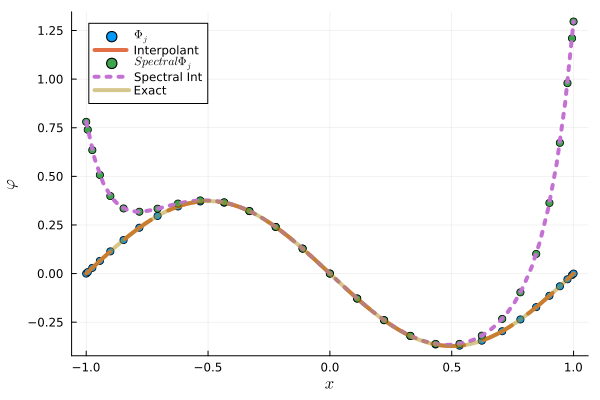

In [92]:


plot(xcheb, phi1,seriestype=:scatter,label=L"\Phi_j", fmt = :png)
plot!(xxx, phiout,linestyle=:dash,linewidth=:4,label="Interpolant", fmt = :png)
plot!(xcheb, phi3,seriestype=:scatter,label=L"Spectral \Phi_j", fmt = :png)
plot!(x4, phiout4,linestyle=:dot,linewidth=:4,label="Spectral Int", fmt = :png)
plot!(xana, phiana,label="Exact",linewidth=:4,alpha=:0.5,fmt=:png)
plot!(xlabel=L"x",ylabel=L"\varphi")

As one can see, the collocation method cannot enforce the boundary conditions in Chebyshev Spectral space. And thus fails.

### 4.4.4 Approximation of Scalar Advection Equation

Advection equation:

\begin{align}
    &\partial_t\varphi + \partial_x \varphi = 0 , && &-1<x<1 \\
    &\varphi(x,0) = \varphi_0(x) , && &-1\leq x \geq 1 \\
    &\varphi(-1,t) = g(t) , && &t>0
\tag{4.83}
\end{align}

Using the collocation method, the advection equation is: 

\begin{align}
    &\partial_t \Phi + \left( D \mathbf{\Phi} \right)_j = 0 , && j=1,....,N, \\
    &\Phi_0 = g(t)
\tag{4.84}
\end{align}

Where $D$ is the derivative matrix computed via Algorithm 37

#### Eigenvalue Analysis of the first derivative matrix ($D$) for Legendre and Chebyshev

We want to see the eigenvalues of the $D$ matrix in order to get an understanding of the time step to use. We use the Gauss-Lobatto nodes

In [93]:
nn = 32
xcheb, wcheb = ChebyshevGaussLobattoNodesAndWeights(nn);
xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 1000, 1.0e-8);

Because of the boundary condition, we remove the first row and column of the matrix (?).

In [94]:
#Get Chebyshev and Legendre Polynomial Derivative Matrices
Dcheb = transpose(PolynomialDerivativeMatrix(xcheb));
Dleg = transpose(PolynomialDerivativeMatrix(xleg));
#Remove the Last column and row
Dcheba = Dcheb[1:end-1, 1:end-1];
Dlega = Dleg[1:end-1, 1:end-1];


In [96]:
#check size
size(Dcheba)

(32, 32)

We can calculate the eigen values and separate into real and imaginary

In [97]:
evcheb = eigen(Dcheba);
evrcheb = real.(evcheb.values) 
evicheb = imag.(evcheb.values) ;

evleg = eigen(Dlega);
evrleg = real.(evleg.values) 
evileg = imag.(evleg.values) ;

Let's plot it

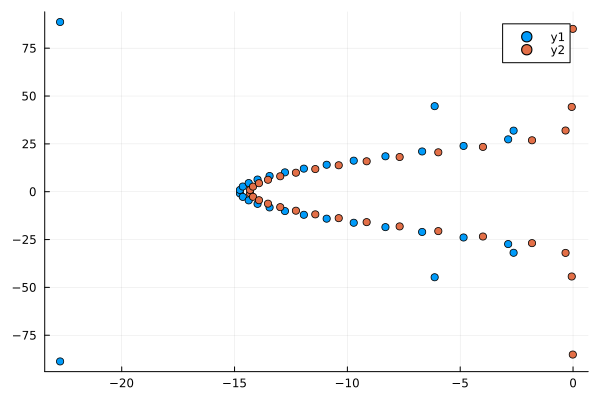

In [98]:
plot(evrcheb, evicheb,seriestype=:scatter, fmt = :png)#, ylimits=(-3*nn,3*nn), xlimits=(-nn,0))
plot!(evrleg, evileg,seriestype=:scatter, fmt = :png)#, ylimits=(-3*nn,3*nn), xlimits=(-nn,0))


This is exactly Fig. 4.9

Now let's look at how the maximum eigenvalue $\lambda_e$ increases with $N$ at $N = 6,10,20,40,60,80,100,120,140$

In [99]:
# list of N
nnn = [6, 10 , 20, 40, 60, 80, 100, 120,140]
#initialize empty lists for max eigenvalues
chebmaxeig = zeros(Float64, length(nnn))
legmaxeig = zeros(Float64, length(nnn))
#loop through all N's
for i in 1:length(nnn)
    #get nodes and weights at N
    xcheb, wcheb = ChebyshevGaussLobattoNodesAndWeights(nnn[i]);
    xleg, wleg = LegendreGaussLobattoNodesAndWeights(nnn[i], 1000, 1.0e-8); 
    #Get Derivative Matrices
    Dcheb = transpose(PolynomialDerivativeMatrix(xcheb));
    Dleg = transpose(PolynomialDerivativeMatrix(xleg));
    #Remove last column and row
    Dcheba = Dcheb[1:end-1, 1:end-1];
    Dlega = Dleg[1:end-1, 1:end-1];
    #calculate eigen values
    evcheb = eigvals(Dcheba);
    evleg = eigvals(Dlega);
    #Calculate max magnitude of eigen valeus 
    chebmaxeig[i] = maximum(abs.(evcheb))
    legmaxeig[i] = maximum(abs.(evleg))

end


In [100]:
#make log log graph with values
nlog = log10.(nnn)
chebeiglog = log10.(chebmaxeig)
legeiglog = log10.(legmaxeig);

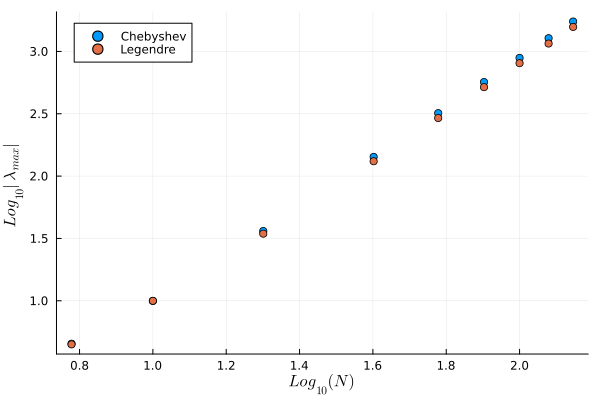

In [105]:
plot(nlog, chebeiglog,seriestype=:scatter, label="Chebyshev", fmt = :png)#, ylimits=(-3*nn,3*nn), xlimits=(-nn,0))
plot!(nlog, legeiglog,seriestype=:scatter, label="Legendre",fmt = :png)#, ylimits=(-3*nn,3*nn), xlimits=(-nn,0))
xlabel!(L"Log_{10}(N)")
ylabel!(L"Log_{10}|\lambda_{max}|")

This is Fig. 4.10

# 4.A Side Quest on Stability of Numerical Methods for ODEs

https://en.wikiversity.org/wiki/Numerical_Analysis/stability_of_RK_methods

https://www.geometrictools.com/Documentation/StabilityAnalysis.pdf

https://webspace.science.uu.nl/~frank011/Classes/numwisk/ch10.pdf

Stability of Numerical Methods is based of the Linear Algebra of Ordinary Differential Equations. 

As an example, if we have an autonomous system (forcing function does not depend on '$t$': $f(x,t) \Rightarrow f(x)$):

\begin{align}
    \partial_t \mathbf{Y}(x,t) = \mathbf{f(x)} , && t \geq 0, \:\:\:\: \mathbf{Y}(x,0) = \mathbf{Y}_0
\tag{4.A1}
\end{align}

If there is an equilibrium solution vector '$\mathbf{c}$' such that:

\begin{align}
    \mathbf{f}(\mathbf{c}) = 0
\end{align}

Then 

\begin{align}
    \mathbf{Y}(t) = \mathbf{c}
\end{align}

Is a solution with: $

\begin{align}
    \mathbf{Y}_0 = \mathbf{c}
\end{align}

This system can then be linarized using taylor expansion:

\begin{align}
    \mathbf{f}(\mathbf{x}) = \mathbf{f}(\mathbf{c}) + \underline{D} \mathbf{f}(\mathbf{c}) (\mathbf{x}-\mathbf{c}) + \mathbf{R}(\mathbf{\bar{x}}) \Rightarrow \underline{D} \mathbf{f}(\mathbf{c}) (\mathbf{x}-\mathbf{c}) + \mathbf{R}(\mathbf{\bar{x}})
\tag{4.A2}
\end{align}

Where the last inequality comes from defining $\mathbf{f}(\mathbf{c}) = 0$

and $D\mathbf{f}(\mathbf{c})$ is the matrix of partial derivatives $D\mathbf{f}(\mathbf{x})_{i,j} = \partial f_i / \partial x_j$

Where $\mathbf{f}(\mathbf{x}) = (f_1, f_2, ... , f_n) $ 

$\mathbf{x} = (x_1, x_2, ... , x_n) $

and $\mathbf{R}(\mathbf{\bar{x}})$ is the remainder with $\mathbf{\bar{x}} $ being so me value dependent on $\mathbf{x}$ and $\mathbf{c}$

We can do a change of variables:  $\mathbf{z} = \mathbf{x} - \mathbf{c}$

\begin{align}
    \partial_t \mathbf{z} = \underline{A}\cdot \mathbf{z}, && t\ge 0, \:\:\:\: \mathbf{z}(0) = 0
\tag{4.A3}
\end{align}

Where $\underline{A} = \underline{D} \mathbf{f}(\mathbf{c})$

The stability of the system is then determined by the eigenvalues of the matrix $\underline{A}$ which are the roots of the polynomial: $p(\lambda) = det(\underline{A} - \lambda\underline{I})$

**Stability of Autonomous System**

1. Every solution is stable if all the eigenvalues of $\underline{A}$ have negative real part
2. Every solution is unstable if at least one eigenvalue of $\underline{A}$ has positive real part.
3. Suppose that the eigenvalues of $\underline{A}$ all have real parts that are zero or negative with at 
least one eigenvalue having zero real part. Not enough information is available to conclud 
whether or not the equilibrium solution is stable. (More analysis must be done.)


### Numerical Stability

In numerical methods, the numerical equation to solve can usually be written in linear form. Using the above autonomous sytem $\partial_t Y(x,t) = f(x,t) $, a numerical integrator can be of the form:

\begin{align}
    Y(t_{i+1}) &= Y(t_i) + h\cdot \left. \partial_t(Y)\right|_{t_i} + \frac{h^2}{2}\cdot \left. \partial_t^2(Y)\right|_{t_i} \\
    &\Rightarrow Y(t_i) + h\cdot  f(x,t_i) + \frac{h^2}{2}\cdot \left. \partial_t^2(Y)\right|_{t_i} 
\tag{4.A4}
\end{align}

Where $h = \Delta t$ is the numerical time step. 

Removing the second order terms and above we get Euler's Equation:

\begin{align}
    Y(t_{i+1}) = Y(t_i) + h\cdot  f(x,t_i)  
\tag{4.A5}
\end{align}

Now we know that $f(x,t_i) = \partial_t Y(t_i)$ which we can write in matrix form as: $\partial_t Y(t_i) \Rightarrow \underline{D}Y(t_i)$ 

Our equation becomes:

\begin{align}
    Y(t_{i+1}) &= Y(t_i) + h \underline{D}\cdot Y(t_i) 
\tag{4.A6}
\end{align}

Now assuming that we're perfect and we found a solution $Y(t_i)$ such that it is an eigen function with eigenvalue $\lambda$ of the operator $\underline{D}$ we can re-write as:

\begin{align}
    Y(t_{i+1}) &= Y(t_i) + h \lambda Y(t_i) \\
    &\Rightarrow (1 + h\lambda ) Y(t_i)
\tag{4.A7}
\end{align}

This is simply the linear autonomous equation from the begining of this section where we can say that some operator is acting on $Y(t_i)$ which gives the eigen value $\Gamma$:

\begin{align}
    Y(t_{i+1}) = \hat{P} Y(t_i) = \Gamma Y(t_i) = (1+h\lambda) Y(t_i)
\tag{4.A8}
\end{align}

Where the eigenvalue: $\Gamma = (1+h\lambda)$

And as before, we follow that this method is stable if all eigenvalues have a negative real part: $\Gamma = h\lambda < 0$

Where $\lambda$ is the eigenvalues of the function $\mathbf{f}(x,t)$. These could be eigenvalues of differential operators such as $\partial_x$ or $\partial_{xx}$ where: $\mathbf{f}(x,t) = \partial_{xx} Y(x,t)$

#### **Stability Function**

We define the **Stability Function** as:

\begin{align}
    R(\hat{h}) = 1 + \hat{h}
\tag{4.A9}
\end{align}

Where $\hat{h} = h \lambda$. And again, $h = \Delta t$ 



#### **Characteristic Polynomial**



We introduce the characteristic polynomial by first looking at an ODE:

\begin{align}
    \partial_t^2 Y + b\:\partial_t Y + c \: Y = 0 
\tag{4.A10}
\end{align}

Say there is a solution:

\begin{align}
    Y = a e^{\lambda t}
\tag{4.A11}
\end{align}

Then we can write the ODE as:

\begin{align}
    \lambda^2 Y + b\:\lambda Y + c \: Y = 0 
\tag{4.A12}
\end{align}

To solve for the eigenvalues we use the quadradic formula to get:

\begin{align}
    \lambda = \frac{-b \pm \sqrt{b^2 - 4\cdot (1) c}}{2}
\tag{4.A13}
\end{align}

As mentioned at the beginning, the solution is **stable** if $\lambda \le 0$.

Assuming $b\ge 0$, then the terms under the square root must come out complex or less than zero for both eigenvalues. 

In terms of the **Stability Function**:

\begin{align}
    p(z) = z - R( \lambda \Delta t)
\tag{4.A14}
\end{align}

We then find the roots of the **Characteristic Polynomial** and find a set of $\lambda\cdot \Delta t$ that will satisfy $\left| R(\lambda \Delta t) \right| \le 1$

#### Stability of Euler Method

Coming back to Euler's method we write:

\begin{align}
    \partial_t Y = \frac{y_{i+1}-y_i}{\Delta t}
\tag{4.A15}
\end{align}

We previously solved for:

\begin{align}
    y_{i+1} = (1 + h \lambda) y_i
\tag{4.A16}
\end{align}

Plugging this into euler's formula for the derivative:

\begin{align}
    \partial_t y_i= \frac{(1 + h \lambda) y_i-y_i}{\Delta t} \Rightarrow \frac{(1 + h \lambda -1) y_i}{\Delta t}
\tag{4.A17}
\end{align}

Knowing $\Delta t > 0$ we write our eigenvalue for $\partial_t y_i = \Gamma y_i$

Where 

\begin{align}
    \Gamma = 1 + h \lambda -1
\tag{4.A18}
\end{align}

In order for this to be stable we need:

\begin{align}
    \Gamma = 1 + h \lambda -1 \le 0
\tag{4.A19}
\end{align}

We can re-write with the stability function:


\begin{align}
    R = 1 + h \lambda \le 1
\tag{4.A20}
\end{align}

## 4.B Stability of RK3

Numerical Stability of RK methods can be found:

https://en.wikiversity.org/wiki/Numerical_Analysis/stability_of_RK_methods


For an ODE of the form: 

\begin{align}
    \partial_t y(t) = F(t; y(t))
\tag{4.B1}
\end{align}

The general form of the Runge-Kutta algorithm is:

\begin{align}
    y_{n+1} = y_n + h \sum_{i=1}^s b_i k_i
\tag{4.B2}
\end{align}

Where

\begin{align}
    k_1 &= h f(t_n, y_n), \\
    k_2 &= h f(t_n + c_2 h, y_n + a_{21} k_1), \\
    k_3 &= h f(t_n + c_3 h, y_n + a_{31} k_1 +a_{32} k_2), \\
    &\vdots
\tag{4.B3}
\end{align}

Where $b_i$, $c_i$, and $a_{ij}$ can be found via the Butcher's Tablaeu:

https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods

### RK3 Stability

Using the following link for the **Williamson's Low Storage RK3 Method**:

https://palm.muk.uni-hannover.de/trac/wiki/doc/tec/rk3

we get the following from the Butcher Tableau:

\begin{align}
    b_1 &= \frac{1}{6} \\
    b_2 &= \frac{3}{10} \\
    b_3 &= \frac{8}{15} \\
    c_1 &= 0 \\
    c_2 &= \frac{1}{3} \\
    c_3 &= \frac{3}{4} \\
    a_{23} &= \frac{1}{3} \\
    a_{31} &= \frac{-3}{16} \\
    a_{32} &= \frac{15}{16}
\end{align}

and all others are zero.

Thus our RK3 equation is:

\begin{align}
    y_{n+1} = y_n + \frac{1}{6}  k_1 +\frac{3}{10} k_2 + \frac{8}{15}  k_3
\tag{4.B4}
\end{align}

Where:

\begin{align}
    k_1 &= h f(t_n, y_n) \\
    k_2 &= h f(t_n + \frac{1}{3} h , y_n + \frac{1}{3} k_1) \\
    k_3 &= h f(t_n + \frac{3}{4} h , y_n - \frac{3}{16} k_1 + \frac{15}{16} k_2 )
\tag{4.B5}
\end{align}

Now we assume that the current solution in time $y_n$ is an eigenfunction of the Right-Hand-Side of the ODE such that:

\begin{align}
    \partial_t y_n = f(t_n,y_n) = \lambda y_n
\tag{4.B6}
\end{align}

Then we re-write Eqn 4.B4 and using the substitution $\hat{h} = h\: \lambda$:

\begin{align}
    k_1 &=  h \: f(t_n,y_n) \Rightarrow h \: \lambda \: y_n \\
    k_2 &= h\: f \left( t_n + \frac{1}{3} h , y_n + \frac{1}{3}\: k_1 \right) \\
        &= h\: \left( 1 + \frac{1}{3} h \:\lambda  \right) \lambda \:y_n \\
        &= \left( \hat{h} + \frac{1}{3} \hat{h}^2 \right)   \:y_n \\
    k_3 &=  h\: f \left(t_n + \frac{3}{4} h , y_n - \frac{3}{16}   k_1 + \frac{15}{16} k_2 \right) \\
        &= h\: \left(1 - \frac{3}{16} (\hat{h}) + \frac{15}{16} \left( \hat{h} + \frac{1}{3} \hat{h}^2 \right)   \right) \lambda\:y_n \\
        &= \left(\hat{h} + \frac{3}{4} \hat{h}^2  + \frac{5}{16}  \hat{h}^3  \right) \:y_n 
\end{align}

And thus our Rk equation becomes:

\begin{align}
    y_{n+1} = \left(1 + \frac{1}{6}\hat{h} + \frac{3}{10} \left( \hat{h} + \frac{1}{3} \hat{h}^2   \right) +\frac{8}{15} \left(\hat{h} + \frac{3}{4} \hat{h}^2  + \frac{5}{16}  \hat{h}^3  \right) \right) y_n
\end{align}



\begin{align}
     y_{n+1} = \left(1 +\hat{h} +\frac{1}{2} \hat{h}^2   +\frac{1}{6} \hat{h}^3   \right) y_n
\tag{4.B7}
\end{align}

Thus our stability function is: 

\begin{align}
    R(\hat{h}) = 1 + \hat{h} +\frac{1}{2} \hat{h}^2   +\frac{1}{6} \hat{h}^3
\tag{4.B8}
\end{align}

And in order for our RK3 method to be stable:

\begin{align}
    \left| R(\hat{h}) \right|  \le 1
\tag{4.B9}
\end{align}

and $\hat{h} = h \: \lambda = \Delta t\: \lambda $

And our $\lambda$ are the eigenvalues of our RHS operator, which in this case is for the advection equation:

\begin{align}
    f(t_n, \varphi_n) = \partial_x \varphi_n
\end{align}

Now let's plot the **Stability Function**: $\left| R(\hat{h}) \le 1\right|$ where we write $\hat{h} = x + i\:y$

In [106]:
# h = x + iy
R(x,y) = 1 + (x+1.0im*y) +0.5*(x+1.0im*y)^2 +1.0/6.0*(x+1.0im*y)^3 

R (generic function with 1 method)

In [107]:
#real part of h
x = range(-3, 0.5, length=1000)
y = range(-3, 3, length=1000)
r = @. R(x', y);
rr = abs.(r);

We can make a countour graph

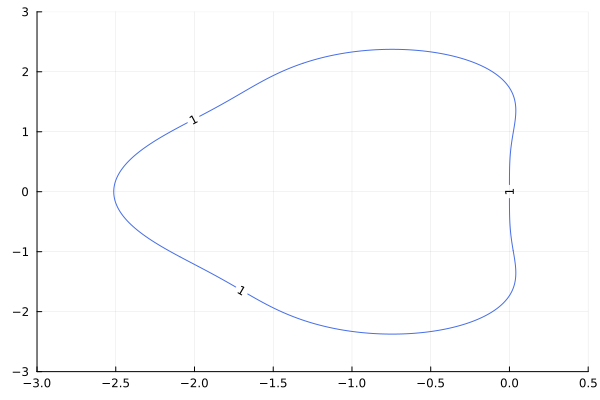

In [108]:
contour(x, y, rr, levels=[1.0], color=:turbo, clabels=true, cbar=false, lw=1, fmt = :png)

According to the book (pg 122 under Figure 4.10), the contour of $\left| R(\hat{h}\right| = 1$ crosses the imaginary axis at $\pm 1.73\: i$

And from **Fig. 4.10** we know that:

\begin{align}
    Chebyshev: && &\lambda_{max} \approx 0.09\: N^2 \\
    Legendre: && &\lambda_{max} \approx 0.08\: N^2
\end{align}

Thus, for Chebyshev:

\begin{align}
    \hat{h} = \lambda_{max} \Delta t \approx 0.09\: N^2 \cdot \Delta t
\end{align}

Now, we assume that the maximum value of $\hat{h}$ is when $\left| R(\hat{h}\right| = 1$ crosses the imaginary axis. 

\begin{align}
    &\hat{h}_{max} = 1.73 \\
    & 0.09\: N^2 \cdot \Delta t_{max} = 1.73 \\
    &\Rightarrow \Delta t_{max} = \frac{1.73}{0.09 \: N^2} 
\end{align}

**NOTE**

For the legendre, for some reason the denominator term is not $0.08$ but instead $0.10$

Let's calculate the eigenvalues for the Derivative Matrix (in the RK3 method) for different $N$.

First let's create a function for the $\Delta t_{max}$ of the Chebyshev and Legendre methods

In [114]:
deltatcheb(NN) = 1.73/0.09 / (NN^2)
deltatleg(NN) = 1.73/0.10 / (NN^2)

deltatleg (generic function with 1 method)

In [115]:
#list of different N's
nn = [8, 16, 32]

3-element Vector{Int64}:
  8
 16
 32

In [116]:
#calculate the dt's
ddtcheb = @. deltatcheb(nn)
ddtleg = @. deltatleg(nn);

In [117]:
#calculate eigenvalues
ceigvr = Array{Any}(nothing, 3)
ceigvi = Array{Any}(nothing, 3)
leigvr = Array{Any}(nothing, 3)
leigvi = Array{Any}(nothing, 3)

for i in 1:length(nn)
    
    xcheb, wcheb = ChebyshevGaussLobattoNodesAndWeights(nn[i]);
    xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn[i], 1000, 1.0e-8);
    Dcheb = transpose(PolynomialDerivativeMatrix(xcheb));
    Dleg = transpose(PolynomialDerivativeMatrix(xleg));
    Dcheba = Dcheb[1:end-1, 1:end-1];
    Dlega = Dleg[1:end-1, 1:end-1];
    
    evcheb = eigen(Dcheba);
    evleg = eigen(Dlega);
    
    ceigvr[i] = @. real.(evcheb.values) .* ddtcheb[i]
    ceigvi[i] =  @. imag.(evcheb.values) .* ddtcheb[i]
    leigvr[i] =  @. real.(evleg.values) .* ddtleg[i]
    leigvi[i] =  @. imag.(evleg.values) .* ddtleg[i]


end

In [162]:
#real part of h
x = range(-3, 0.5, length=1000)
y = range(-3, 3, length=1000)
r = @. R(x', y);
rr = abs.(r);

Now let's plot the eigenvalues for different $N$ of the Chebyshev method given the approximate $\Delta t_{max}$

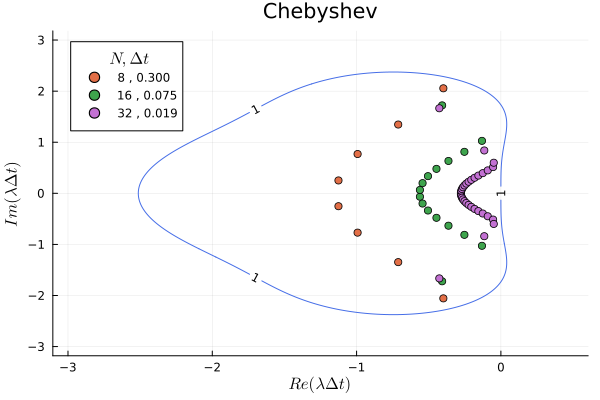

In [118]:
contour(x, y, rr, levels=[1.0], color=:turbo, clabels=true, cbar=false, lw=1, fmt = :png)
plot!(ceigvr[1], ceigvi[1],seriestype=:scatter, fmt = :png, label=string("$(nn[1]) , ",@sprintf( "%0.3f",ddtcheb[1]) ))
plot!(ceigvr[2], ceigvi[2],seriestype=:scatter, fmt = :png, label=string("$(nn[2]) , ",@sprintf( "%0.3f",ddtcheb[2])))
plot!(ceigvr[3], ceigvi[3],seriestype=:scatter, fmt = :png, label=string("$(nn[3]) , ",@sprintf( "%0.3f",ddtcheb[3])))
plot!(title="Chebyshev", legendtitle = L"N , \Delta t")
xlabel!(L"Re(\lambda \Delta t)")
ylabel!(L"Im(\lambda \Delta t)")

And for the Legendre Method

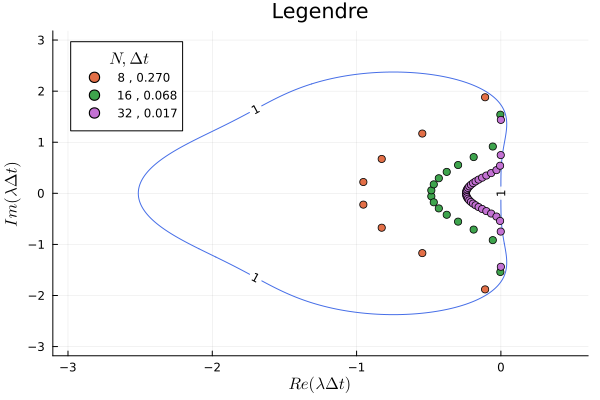

In [119]:
contour(x, y, rr, levels=[1.0], color=:turbo, clabels=true, cbar=false, lw=1, fmt = :png)
plot!(leigvr[1], leigvi[1],seriestype=:scatter, fmt = :png, label=string("$(nn[1]) , ",@sprintf( "%0.3f",ddtleg[1]) ))
plot!(leigvr[2], leigvi[2],seriestype=:scatter, fmt = :png, label=string("$(nn[2]) , ",@sprintf( "%0.3f",ddtleg[2]) ))
plot!(leigvr[3], leigvi[3],seriestype=:scatter, fmt = :png, label=string("$(nn[3]) , ",@sprintf( "%0.3f",ddtleg[3]) ))
plot!(title="Legendre", legendtitle = L"N , \Delta t")
xlabel!(L"Re(\lambda \Delta t)")
ylabel!(L"Im(\lambda \Delta t)")

Compare these to **Figure 4.11** on Page 123

We see that our $\Delta t_{max}$ approximations are very good

# 4.5 The Legendre Galerkin Method

The heat equation:

\begin{align}
\partial_t \varphi &=  \partial_{xx} \varphi \:\:\:, \:\:\:\:\: -1\lt x \lt 1 \:\:, \\
\varphi(x,0) &= \varphi_0(x) \:\:\:, \:\:\:\:\: -1\lt x \lt 1 \\
\varphi(-1,t) &= \varphi(1,t) =0
\tag{4.85}
\end{align}

Assum $\nu >0$

The solution is approximated via polynomial:

\begin{align}
    \varphi \approx \Phi = \sum \hat{\Phi}_k(t) \phi_k
\tag{4.86}
\end{align}

$\phi_k$ - The basis function that satisfies boundary conditions

$\hat{\Phi}_k(t)$ - expansion coefficients determined from weak form

We need to choose a proper basis function out of the Legendre functions to satisfy the boundary conditions:

\begin{align}
    \phi_k(x) = \frac{1}{\sqrt{4 k + 6}} \left[ L_k(x) - L_{k+2}(x) \right]
\tag{4.87}
\end{align}

So we can write a polynomial of degree $N$:

\begin{align}
    \Phi = \sum_{k=0}^{N-2} \hat{\Phi}_k(t) \: \phi_k
\tag{4.88}
\end{align}

Through the weak form and Galerkin approximation we then get:

\begin{align}
    \sum_{k=0}^{N-2} \dot{\hat{\Phi}}_k \left( \phi_k, \phi_n \right) + \sum_{k=0}^{N-2} \hat{\Phi}_k \left( \phi_k', \phi_n' \right) = 0
\tag{4.90}
\end{align}

Which can be written in matrix form with:

\begin{align}
    M_{kn} &= \left( \phi_k, \phi_n \right) \\
    S_{kn} &= \left( \phi_k', \phi_n' \right) \\
    \mathbf{\hat{\Phi}} &= \left[ \hat{\Phi}_0 \:\: \hat{\Phi}_1 \:\:  \cdots \:\: \hat{\Phi}_{N-2}\right]^T
\end{align}

\begin{align}
    \underline{M} \mathbf{\dot{\hat{\Phi}}} = -\underline{S} \mathbf{\hat{\Phi}}
\tag{4.91}
\end{align}

The $\underline{S}$ matrix is particularly simple:

\begin{align}
    \left( \phi_k', \phi_n' \right) = \delta_{k,n}
\tag{4.94}
\end{align}

For the  $\underline{M}$ matrix:

\begin{align}
    \left( \phi_k, \phi_n \right) = \alpha_k \alpha_n \left[ \beta_k \delta_{k,n} + \gamma_n \delta_{k+2,n}  +\mu_n \delta_{k,n+2}   \right]
\tag{4.95}
\end{align}

Where:

\begin{align}
    \alpha_n &= 1/\sqrt{4 n +6} \\
    \gamma_n &= -2/(2 n + 1) \\
    \mu_n &= -2/(2 n + 5) \\
    \beta_n &= -(\gamma_n + \mu_n)
\tag{4.96}
\end{align}

The $\underline{M}$ matrix can be furter split into even and odd. It will not be repeated her but are provided in the book from **Eqn 4.97** - **Eqn 4.103** 

**Initial Conditions Basis Functions**

The Galerkin method approximates the initial polynomial (Legendre) coefficients of the initial conditions $\varphi_0$ via orthogonal polynomial truncation.

\begin{align}
    \Phi_0 = P_N \varphi_0 = \sum_{k=0}^{N} ( \hat{\varphi}_0  )_k \: L_k(x)
\tag{4.104}
\end{align}

Now remember that our basis function is actually **Eqn 4.87** which is not exactly **Eqn 4.104**, so we need to convert to the basis functions of  **Eqn 4.87**.

Thus, $(\hat{\varphi}_0)_k$ are the Legendre coefficients of the transformed initial conditions $\varphi_0$. From these, we need to find our actual coefficients $\hat{\Phi}_k^0$ in our actual basis function that satisfies the initial conditions

To get $\hat{\Phi}_k^0$ we use the orthogonality property of the Legendre and our new Basis Function:

\begin{align}
    \sum_{k=0}^{N-2} \hat{\Phi}_k^0  \left( \phi_k, \phi_m \right) = \sum_{k=0}^{N} ( \hat{\varphi}_0  )_k  \left( L_k, \phi_m \right) && m = 0, \cdots , N-2
\tag{4.105}
\end{align}

The results for the inner product on the left come from **Eqn 4.95**. On the right, we get:

\begin{align}
    \left( L_k, \phi_m \right) = -\alpha_m \gamma_m \delta_{km} + \mu_m \alpha_m \delta_{k,m+2}
\tag{4.106}
\end{align}

#### 4.5.1A Legendre Transform

##### Naive legendre Transform

The book, unfortunately, does not show how to do a proper Legendre transform. Therefore, we must make our own. 

According to wikipedia, the **naive** Normalized Legendre Transform: https://en.wikipedia.org/wiki/Finite_Legendre_transform#:~:text=The%20finite%20Legendre%20transform%20fLT,interval%20into%20its%20Legendre%20spectrum.

\begin{align}
    \tilde{L}_k = \frac{2\: k + 1 }{N} \sum_{j=0}^{N} f(x_j)\: L_k(x_j)
\tag{4.5.1a}
\end{align}

We are using Gauss-Lobatto quadrature points with weights and we require unnormalized Legendre coefficients in order to take a discrete time step, we re-write the transform as: 

\begin{align}
    \tilde{L}_k = \sum_{j=0}^{N} w_j f(x_j)\: L_k(x_j)
\tag{4.5.1b}
\end{align}

Below the **LegendreTransformNaive** is the algorithm which does **Eqn 4.5.1b** which is a naive summation which is extremely slow.

In [120]:
function LegendreTransformNaive(Phi::Array{Float64}, x::Array{Float64}, w::Array{Float64})

    N = length(Phi)
    Phik = zeros(Float64, N)
    #Lk = zeros(Float64,N)
    #Lkk = zeros(Float64,N)
    ll = 0.0
    den = 0.0

    for k in 1:N
        #@. Lk = 0.0
        #@. Lkk = 0.0
        #calculate legendre functions at x[k]
        den = 0.0
        for j in 1:N
            #Lk[j] = LegendrePolynomial(k-1, x[j])
            ll = LegendrePolynomial(k-1, x[j])
            Phik[k] = Phik[k] + w[j]*Phi[j]*ll
            den = den + ll^2 *w[j]
        end

        Phik[k] = Phik[k]/den
        # @. Lkk = w*Phi*Lk
        # Phik[k] = sum(Lkk)
        # if k<N
        #     Phik[k] = Phik[k]*((k-1)+0.5)
        #     #Phik[k] = Phik[k]*((k-1)+0.5)
        # else
        #     Phik[k] = Phik[k]*(N*0.5)
        # end

    end

    return Phik

end

function InverseLegendreTransformNaive(Phik::Array{Float64}, x::Array{Float64}, w::Array{Float64})

    N = length(Phik)
    Phi = zeros(Float64, N)
    #Lk = zeros(Float64,N)
    #Lkk = zeros(Float64,N)
    ll = 0.0
    kk = 0.0
    den = 0.0

    for j in 1:N
        #@. Lk = 0.0
        #@. Lkk = 0.0
        #calculate legendre functions at x[k]
        den = 0.0
        for k in 1:N
            #Lk[j] = LegendrePolynomial(k-1, x[j])
            ll = LegendrePolynomial(k-1, x[j])
            #kk = 2.0*(k-1)+1
            Phi[j] = Phi[j] + Phik[k]*ll
            #Phi[j] = Phi[j] + w[j]*Phik[k]*ll
            #den = den + ll^2 *w[j]
        end

        #@. Phi = Phi*N
        #Phik[k] = Phik[k]/den
        # @. Lkk = w*Phi*Lk
        # Phik[k] = sum(Lkk)
        # if k<N
        #     Phik[k] = Phik[k]*((k-1)+0.5)
        #     #Phik[k] = Phik[k]*((k-1)+0.5)
        # else
        #     Phik[k] = Phik[k]*(N*0.5)
        # end

    end

    return Phi

end

InverseLegendreTransformNaive (generic function with 1 method)

##### Fast Legendre Transform

There are other algorithms that are being researched right now in order to make the Legendre transform faster. One of these algorithms is in the **FastTransforms.jl** library. 

It first does a **Chebyshev Transform** then does a **Chebyshev to Legendre Transform**. Because the Chebyshev transform can use the Discrete Cosine Transform (i.e. Fast Fourier Algorithms) it should allow for faster transform. 

The algorithm **FastLegendreTransform** below shows how to do this. 

In [121]:
function FastLegendreTransform(Phi::Array{Float64}, planf, planchebtoleg)

    N = length(Phi)
    phikcheb = zeros(Float64, N)
    phikleg = zeros(Float64, N)

    phikcheb = FastChebyshevTransform2(Phi, planf);
    phikleg = planchebtoleg*phikcheb;

    return phikleg

end

function FastInverseLegendreTransform(Phik::Array{Float64}, planb, planlegtocheb)

    N = length(Phik)
    phikcheb = zeros(Float64, N)
    phi = zeros(Float64, N)

    phikcheb = planlegtocheb*Phik;
    phi = InvFastChebyshevTransform2(phikcheb, planb)#FastChebyshevTransform2(phikcheb, planb);
    #@. phi = phi*N;

    return phi

end

FastInverseLegendreTransform (generic function with 1 method)

In [122]:

#using only FastTransforms.jl
function FastTransformsLegendre(Phi::Array{Float64}, plancheb, planchebtoleg)

    N = length(Phi)
    phikcheb = zeros(Float64, N)
    phikleg = zeros(Float64, N)

    phikcheb = plancheb*Phi;
    phikleg = planchebtoleg*phikcheb;

    return phikleg

end

function FastInverseTransformsLegendre(Phik::Array{Float64}, planinvcheb, planlegtocheb)

    N = length(Phik)
    phikcheb = zeros(Float64, N)
    phi = zeros(Float64, N)

    phikcheb = planlegtocheb*Phik;
    phi = planinvcheb*phikcheb;

    return phi

end



FastInverseTransformsLegendre (generic function with 1 method)

##### Testing Legendre Transforms

We will now test the two **Legendre Transforms** algorithms below.

We will use the 2nd through 5th Legendre Polynomials on the Gauss-Lobatto Points: https://en.wikipedia.org/wiki/Legendre_polynomials

\begin{align}
    f(x) = L_2(x) + L_3(x) + L_4(x) + L_5(x)
\end{align}


We will see that the Legendre and Chebyshev GL points are very close to each other which makes the fast Legendre Transform via Chebyshev transform useful

In this example let's use $N_{total} = 401$

In [123]:
nn = 400
xcheb, wcheb = ChebyshevGaussLobattoNodesAndWeights(nn);
xcheb = xcheb[end:-1:1] #NOTE: The FastTransforms use reverse from max positive to negative
xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 10000, 1.0e-6);

We'll do the Legendre Polynomial sum from 2 through 5 at the Chebyshev and Legendre Gauss-Lobatto Points

In [125]:
phi0c = @. 0.5*(3*xcheb^2 - 1) + 0.5*(5*xcheb^3 - 3*xcheb)+ 1/8*(35*xcheb^4 - 30*xcheb^2 + 3) + 1/8.0*(63*xcheb^5 -70*xcheb^3 + 15*xcheb)#sin(pi*(xcheb+1))*exp(-kk^2 * pi^2 *t0);# + 1.0im;
#phi0[end] = 0.0

phi0l = @. 0.5*(3*xleg^2 -1) + 0.5*(5*xleg^3 - 3*xleg) + 1/8*(35*xleg^4 - 30*xleg^2 + 3) + 1/8.0*(63*xleg^5 -70*xleg^3 + 15*xleg);#sin(pi*(xleg+1))*exp(-kk^2 * pi^2 *t0);# + 1.0im;
#phi0l[end] = 0.0

Let's plot them to make sure they give the same answer

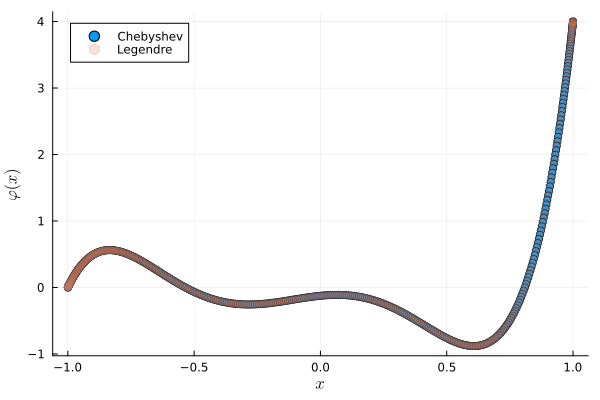

In [126]:
plot(xcheb, phi0c,seriestype=:scatter,  label=string("Chebyshev"),format=:png)
plot!(xleg, phi0l,seriestype=:scatter, label=string("Legendre"),marker = ([:hex :d], 4, 0.2, Plots.stroke(1, :gray))
,format=:png)
xlabel!(L"x")
ylabel!(L"\varphi(x)")

Restart with our initial $\Phi_0$ and let's create a FFTW plan for the Fast Chebyshev Transform

In [127]:
phi1 = deepcopy(phi0c);
phi2 = deepcopy(phi0c);
phi3 = deepcopy(phi0c);

#DCT-I plan for Chebyshev Transform
pr0 = FFTW.plan_r2r(phi2, FFTW.REDFT00,flags=FFTW.MEASURE);
phi2 = deepcopy(phi0c);

Formulate transform plans using FastTransforms.jl.
Note that when you make plans, the array used to create the plan is written into and no longer useful. So you ahve to re-initialize it

In [130]:
#FastTransforms.jl 
#make transform plans for speed
pcheb = FastTransforms.plan_chebyshevtransform(phi2,Val(2),flags=FFTW.MEASURE);
phi2 = deepcopy(phi0c);
pchebi = FastTransforms.plan_ichebyshevtransform(phi2,Val(2),flags=FFTW.MEASURE);
phi2 = deepcopy(phi0c);
pctol = FastTransforms.plan_cheb2leg(phi2,normcheb=false, normleg=false);
phi2 = deepcopy(phi0c);
pltoc = FastTransforms.plan_leg2cheb(phi2,normcheb=false, normleg=false);
phi2 = deepcopy(phi0c);

Now let's do the transforms to compare

In [131]:
phi0kl = LegendreTransformNaive(phi0l, xleg, wleg);
phi0kcl = FastLegendreTransform(phi1, pr0, pctol);
phiFTcl = FastTransformsLegendre(phi3, pcheb, pctol);
#phi1kl = LegendreTransform(phi1, xcheb, wcheb);

Let's check to see that all Legendre coefficients active in our equation give $1$ while the rest are near zero

In [132]:
println("Naive \t\t\t DCT-I \t\t\t FastT")
println("-------------------------------------------------------------")
for i in 1:10
    #@printf("%.1e, \t\t %.1e, \t\t %.1e\n", phi0kl[i], phi0kcl[i],phi1kcl[i])
    @printf("%.1e, \t\t %.1e, \t\t %.1e\n", phi0kl[i], phi0kcl[i], phiFTcl[i])
    #println(phi0kl[i], "\t\t", phi1kl[i], "\t\t",phi0kcl[i])
    #println(phi0kl[i],  "\t\t",phi0kcl[i])

end 

Naive 			 DCT-I 			 FastT
-------------------------------------------------------------
1.1e-11, 		 -1.4e-16, 		 -1.4e-16
5.5e-11, 		 -4.6e-16, 		 -4.6e-16
1.0e+00, 		 1.0e+00, 		 1.0e+00
1.0e+00, 		 1.0e+00, 		 1.0e+00
1.0e+00, 		 1.0e+00, 		 1.0e+00
1.0e+00, 		 1.0e+00, 		 1.0e+00
5.1e-10, 		 3.5e-16, 		 3.5e-16
7.8e-10, 		 1.8e-16, 		 1.8e-16
9.7e-10, 		 4.6e-16, 		 4.6e-16
1.3e-09, 		 2.1e-16, 		 2.1e-16


As we can see, all methods provide the correct coefficient of $1$ for $\tilde{L}_2$, $\tilde{L}_3$,  $\tilde{L}_4$, $\tilde{L}_5$

Now let's time it:

In [133]:
@btime LegendreTransformNaive(phi0kl, xleg, wleg);

  72.605 ms (1 allocation: 3.31 KiB)


In [134]:
@btime FastLegendreTransform(phi1, pr0, pctol);

  75.164 μs (122 allocations: 26.72 KiB)


In [135]:
@btime FastTransformsLegendre(phi3, pcheb, pctol);

  77.996 μs (153 allocations: 24.20 KiB)


Clearly the `FastTransformsLegendre()` is 10x faster than the Naive algorithm

now let's test the **INVERSE** and see if it gives the original result

In [137]:
phi0li = InverseLegendreTransformNaive(phi0kl, xleg,wleg);
phi0kcli = FastInverseLegendreTransform(phi0kcl, pr0, pltoc);
phiFTcli = FastInverseTransformsLegendre(phiFTcl, pchebi, pltoc);



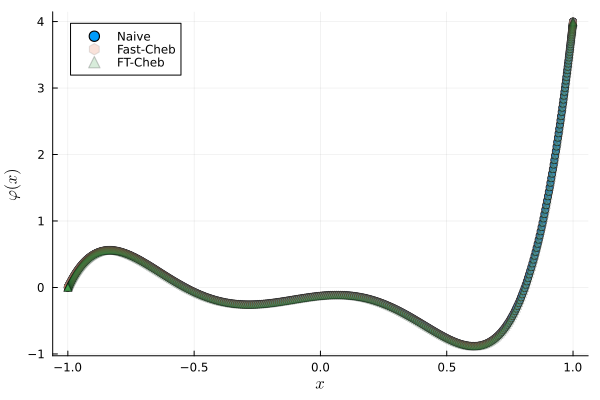

In [138]:
plot(xleg, phi0li,seriestype=:scatter,  label=string("Naive"),format=:png)
plot!(xcheb, phi0kcli,seriestype=:scatter, label=string("Fast-Cheb"),marker = ([:hex :d], 4, 0.2, Plots.stroke(1, :gray)),format=:png)
plot!(xcheb, phiFTcli,seriestype=:scatter, label=string("FT-Cheb"),marker = ([:utriangle :d], 4, 0.2, Plots.stroke(1, :black)),format=:png)
xlabel!(L"x")
ylabel!(L"\varphi(x)")

All looks good!

Let's time the inverse

In [139]:
@btime InverseLegendreTransformNaive(phi0kl, xleg,wleg);


  75.793 ms (1 allocation: 3.31 KiB)


In [140]:
@btime FastInverseLegendreTransform(phi0kcl, pr0, pltoc);


  75.171 μs (123 allocations: 29.97 KiB)


In [141]:
@btime FastInverseTransformsLegendre(phiFTcl, pchebi, pltoc);

  86.899 μs (256 allocations: 27.59 KiB)


### 4.5.1 How to Implement

In [145]:
#alg 52
#ch 4.5.1 pg 127
#Legendre basis modified to vanish at endpoints
function ModifiedLegendreBasis(k::Int64, x::Float64)

    phik = (LegendrePolynomial(k, x) - LegendrePolynomial(k+2, x))/sqrt(4.0*k + 6.0)

    return phik   

end

ModifiedLegendreBasis (generic function with 1 method)

In [146]:
#alg 53
#ch 4.5.1 pg 127
#Synthesis of Legendre Galerkin Solution at different x from original x
function EvaluateLegendreGalerkinSolution(N::Int64, x::Array{Float64}, Phik::Array{Float64})

    M = length(x)
    Phiout = zeros(Float64, M)
    for i in 1:M
        for k in 0:N-2
            Phiout[i] =Phiout[i] + Phik[k+1] * ModifiedLegendreBasis(k, x[i])
        end
    end

    return Phiout

end

EvaluateLegendreGalerkinSolution (generic function with 1 method)

In [147]:
#eqns 4.96 on pg 125
alpha(n::Int64) = 1.0/sqrt(4.0*n + 6.0)
gamma(n::Int64) = -2.0/(2.0*n + 1.0)
mu(n::Int64) = -2.0/(2.0*n + 5.0)
beta(n::Int64) = -(gamma(n) + mu(n))

#alg 54
#ch 4.5.1 pg 128
#Legendre Galerkin Tridiagonal Matrix
function initTMatrix(N::Int64, p::Int64)

    l = zeros(Float64, N) 
    d = zeros(Float64, N+1)
    u = zeros(Float64, N)

    for j in 0:N
        jj = j+1
        d[jj] = beta(2*j+p)*alpha(2*j+p)^2
    end

    for j in 1:N
        l[j] = gamma(2*j+p) * alpha(2*j+p) * alpha(2*(j-1)+p)
        jj = j-1
        u[j] = mu(2*jj+p) * alpha(2*jj+p) * alpha(2*(jj+1)+p)
    end
    
    return l, d, u
end

#alg 54b
#Legendre Galerkin Bidiagonal Matrix
function initTMatrixUpperBidiagonal(N::Int64)

    #l = zeros(Float64, N) 
    # d = zeros(Float64, N)
    # u = zeros(Float64, N-1)
    bidim = zeros(Float64, (N-1, N+1))

    for k in 0:N
        kk = k+1
        for m in 0:(N-2)
            mm = m+1
            if m==k
                bidim[mm,kk] = -alpha(m)*gamma(m)
            elseif m+2==k
                bidim[mm,kk] = mu(m) * alpha(m)
            end

        end
    end

    bidim = sparse(bidim)

    # for j in 0:N-1
    #     jj = j+1
    #     d[jj] = -alpha(2*j+p)*gamma(2*j+p)
    # end

    # for j in 1:N-1
    #     # l[j] = gamma(2*j+p) * alpha(2*j+p) * alpha(2*(j-1)+p)
    #     jj = j-1
    #     u[j] = mu(2*jj+p) * alpha(2*jj+p) 
    # end
    
    return bidim#d, u
end

initTMatrixUpperBidiagonal (generic function with 1 method)

In [148]:
#alg 55
#ch 4.5.1 pg 128
#Modified Legendre Coefficients from Legendre Coefficients
function ModifiedCoefsFromLegendreCoefs(N::Int64, phik::Array{Float64}, Te::Tridiagonal{Float64, Vector{Float64}}, To::Tridiagonal{Float64, Vector{Float64}})

    #even indices
    Me = floor(Int64, (N-2)/2)
    Mo = floor(Int64, (N-2+1)/2) -1
    #L, D, U = initTMatrix(M, 0)

    #computing RHS into modified basis from Legendre coefficients
    rhse = zeros(Float64, Me+1)
    rhso = zeros(Float64, Mo+1)
    Phik = zeros(Float64, N-1)
    
    for j in 0:Me
        #jj = j+1
        rhse[j+1] = mu(2*j) * alpha(2*j) * phik[(2*j+2)+1] - alpha(2*j) * gamma(2*j) * phik[(2*j)+1]

    end

    #T= Tridiagonal(L, D, U)
    B = Te\rhse;

    for j in 0:Me
        jj = j+1
        Phik[(2*j)+1] = B[jj]
    end

    #odd indices
    #M = floor(Int64, (N-2+1)/2) -1
    #L, D, U = initTMatrix(M, 1)
    
    for j in 0:Mo
        jj = j+1
        rhso[jj] = mu(2*j+1) * alpha(2*j+1) * phik[(2*j+3)+1] - alpha(2*j+1) * gamma(2*j+1) * phik[(2*j+1)+1]

    end

    #T = Tridiagonal(L, D, U)
    B = To\rhso;

    for j in 0:Mo
        jj = j+1
        Phik[(2*j+1)+1] = B[jj]
    end

    return Phik
    
end

#alg 55b
function ModifiedCoefsFromLegendreCoefsMatrix(N::Int64, phik::Array{Float64}, Te::Tridiagonal{Float64, Vector{Float64}}, To::Tridiagonal{Float64, Vector{Float64}})

    #modified PhiK
    Phik = zeros(Float64, N-1)
    #rhs bidiagonal sparse matrix
    bidiagm = initTMatrixUpperBidiagonal(N);
    rhsk = bidiagm*phik
    #even indices
    rhse = @view rhsk[1:2:end]
    # phike = @view phik[1:2:end] #note julia indices start from 1
    # Me = length(phike)
    Me = length(rhse)
    # #odd indices
    rhso = @view rhsk[2:2:end]
    # phiko = @view phik[2:2:end]#note julia indices start from 1
    # Mo = length(phiko)
    Mo = length(rhso)
    #L, D, U = initTMatrix(M, 0)

    #computing RHS into modified basis from Legendre coefficients
    #using bidiagonal matrix
    #db, ub = initTMatrixUpperBidiagonal(Me, 0);
     
    # be = Bidiagonal(db, ub, :U);
    # rhse = be*phike;
    

    #T= Tridiagonal(L, D, U)
    B = Te\rhse;

    for j in 0:Me-1
        jj = j+1
        Phik[(2*j)+1] = B[jj]
    end

    #using bidiagonal matrix
    # db, ub = initTMatrixUpperBidiagonal(Mo, 1);
    # bo = Bidiagonal(db, ub, :U);
    # rhso = bo*phiko;

    #T = Tridiagonal(L, D, U)
    B = To\rhso;

    for j in 0:Mo-1
        jj = j+1
        Phik[(2*j+1)+1] = B[jj]
    end

    return Phik
    
end

ModifiedCoefsFromLegendreCoefsMatrix (generic function with 1 method)

In [149]:
# alg 56
#ch 4.5.1 pg 130
#Take one step by trapezoidal rule
function LegendreGalerkinStep(N::Int64, dt::Float64, Phik::Array{Float64})

    
    
    Phiknew = zeros(Float64, N-2+1)
    #even indices
    Me = floor(Int64, (N-2)/2 )
    rhse = zeros(Float64, Me+1)
    phije = zeros(Float64, Me+1)
    #odd indices
    Mo = floor(Int64, (N-2+1)/2) -1
    rhso = zeros(Float64, Mo+1)
    phijo = zeros(Float64, Mo+1)
    
    #begin calculating even indices
    l,d,u = initTMatrix(Me, 0)
    rhse[1] = (d[1] - dt/2.0) * Phik[1] + u[1] * Phik[2+1]

    for j in 1:Me-1
        jj = j+1
        rhse[jj] = l[jj] * Phik[2*(j-1)+1] + (d[jj] - dt/2.0) * Phik[2*j + 1] + u[jj] * Phik[2*(j+1)+1]
    end

    rhse[Me+1] = (d[Me+1] - dt/2.0) * Phik[2*Me+1] + l[Me] * Phik[2*(Me-1)+1]

    for j in 0:Me
        jj = j+1
        d[jj] = d[jj] + dt/2.0

    end

    Te = Tridiagonal(l, d, u)
    phije = Te\rhse

    for j in 0:Me
        jj = j+1
        Phiknew[2*j+1] = phije[jj]
    end

    #Calculate Odd Indices
    l,d,u = initTMatrix(Mo, 1)
    rhso[1] = (d[1] - dt/2.0) * Phik[1+1] + u[1] * Phik[3+1]

    for j in 1:Mo-1
        jj = j+1
        rhso[jj] = l[jj] * Phik[2*(j-1)+1+1] + (d[jj] - dt/2.0) * Phik[2*j+1+1] + u[jj] * Phik[2*(j+1)+1+1]
    end

    rhso[Mo+1] = (d[Mo+1] - dt/2.0) * Phik[2*Mo+1+1] + l[Mo] * Phik[2*(Mo-1) + 1 + 1]

    for j in 0:Mo
        jj = j+1
        d[jj] = d[jj] + dt/2.0

    end

    To = Tridiagonal(l, d, u)
    phijo = To\rhso

    for j in 0:Mo
        jj = j+1
        Phiknew[2*j+1+1] = phijo[jj]
    end    

    return Phiknew
    
end


# alg 56b
function LegendreGalerkinStepMatrix(N::Int64, Phik::Array{Float64},RHSe::Tridiagonal{Float64, Vector{Float64}}, RHSo::Tridiagonal{Float64, Vector{Float64}},LHSe::Tridiagonal{Float64, Vector{Float64}}, LHSo::Tridiagonal{Float64, Vector{Float64}})

    
    
    Phiknew = zeros(Float64, N-2+1)
    #even indices
    phike = @view Phik[1:2:end]
    #Me = floor(Int64, (N-2)/2 )
    Me = length(phike)
    #odd indices
    phiko = @view Phik[2:2:end]
    #Mo = floor(Int64, (N-2+1)/2) -1
    Mo = length(phiko)
    
    #begin calculating even indices
    #eqn 4.108
    #rhsemat = Te - I(Me+1).*dt./2.0
    #lhsemat = Te + I(Me+1).*dt./2.0

    rhse = RHSe*phike#RHSe*Phik
    phije = LHSe\rhse

    for j in 0:Me-1
        jj = j+1
        Phiknew[2*j+1] = phije[jj]
    end

    #Calculate Odd Indices
    #eqn 4.108
    # rhsomat = To - I(Mo+1).*dt./2.0
    # lhsomat = To + I(Mo+1).*dt./2.0

    rhso = RHSo*phiko#RHSo*Phik
    phijo = LHSo\rhso

    for j in 0:Mo-1
        jj = j+1
        Phiknew[2*j+1+1] = phijo[jj]
    end    

    return Phiknew
    
end

LegendreGalerkinStepMatrix (generic function with 1 method)

We need to modify Algorithm 47 for the Legendre Galerkin Driver

In [162]:
#alg 47B
function LegendreGalerkinDriver!(Phi::Array{Float64}, NT::Int64, dt::Float64, nu::Float64, Nout::Int64, planchebf, planchebtoleg)

    #dt = Ttot/NT
    tn = 0.0
    N = length(Phi)-1
    Phik = FastLegendreTransform(Phi, planchebf, planchebtoleg);
    Me = floor(Int64, (N-2)/2)
    Mo = floor(Int64, (N-2+1)/2) -1
    lE, dE, uE = initTMatrix(Me, 0)
    lO, dO, uO = initTMatrix(Mo, 1)
    TE = Tridiagonal(lE, dE, uE)
    TO = Tridiagonal(lO, dO, uO)
    phik = ModifiedCoefsFromLegendreCoefs(N, Phik, TE, TO)#zeros(ComplexF64, size(Phik))

    for n in 0:NT-1
        phik = LegendreGalerkinStep(N, dt, phik)
    end

    return phik
    

end

#alg 47B
function LegendreGalerkinDriverMatrix!(Phi::Array{Float64}, NT::Int64, dt::Float64, nu::Float64, Nout::Int64, planchebf, planchebtoleg)

    #dt = Ttot/NT
    tn = 0.0
    N = length(Phi)-1
    Phik = FastLegendreTransform(Phi, planchebf, planchebtoleg);
    Me = floor(Int64, (N-2)/2)
    Mo = floor(Int64, (N-2+1)/2) -1
    lE, dE, uE = initTMatrix(Me, 0)
    lO, dO, uO = initTMatrix(Mo, 1)
    TE = Tridiagonal(lE, dE, uE)
    TO = Tridiagonal(lO, dO, uO)
    RHSmateven = TE - I(Me+1).*dt./2.0
    LHSmateven = TE + I(Me+1).*dt./2.0
    RHSmatodd = TO - I(Mo+1).*dt./2.0
    LHSmatodd = TO + I(Mo+1).*dt./2.0

    
    phik = ModifiedCoefsFromLegendreCoefsMatrix(N, Phik, TE, TO)


    for n in 0:NT-1
        phik = LegendreGalerkinStepMatrix(N, phik,RHSmateven, RHSmatodd,LHSmateven, LHSmatodd)
        #tn = (n+1)*dt
    end
    
    dx = 2.0/Nout
    x = [j for j in -1:dx:1]
    Phiout = EvaluateLegendreGalerkinSolution(N, x, phik)

    return x, Phiout, phik
    

end

LegendreGalerkinDriverMatrix! (generic function with 1 method)

We will again the example of **Eqn 4.82**

In [156]:
#exact analytic solution
xana = [i for i in -1.0:2.0/200.0:1.0]
tana = 0.0
kana = 1.0
phiana0 = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);
tana = 0.1
kana = 1.0
phiana = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);

In [157]:
nn = 24
xcheb, wcheb = ChebyshevGaussLobattoNodesAndWeights(nn);
xcheb = xcheb[end:-1:1] #NOTE: The FastTransforms use reverse from max positive to negative

t0 = 0.0
k = 1.0
phi0 = @. sin(pi*(xcheb+1))*exp(-k^2 * pi^2 *t0);
phi1 = deepcopy(phi0);
phi2 = deepcopy(phi0);
phi3 = deepcopy(phi0);

In [163]:
nout = 2*Int(1.0*length(xcheb))
ttot = 0.1
nt = 10000
nu = 0.2;
dt = ttot/nt;

pr = FFTW.plan_r2r(phi2, FFTW.REDFT10,flags=FFTW.MEASURE);
pr0 = FFTW.plan_r2r(phi2, FFTW.REDFT00,flags=FFTW.MEASURE);
pctol = FastTransforms.plan_cheb2leg(phi2,normcheb=false, normleg=false);
phi2 = deepcopy(phi0);

In [160]:
xout, phi0out, phikk = LegendreGalerkinDriverMatrix!(phi0,nt, dt, nu, nout, pr0, pctol);

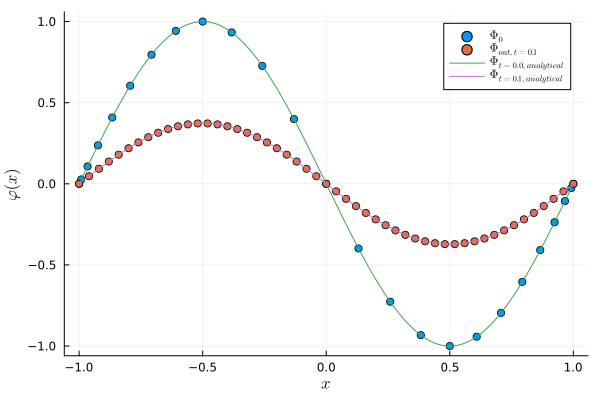

In [161]:
plot(xcheb, phi1,seriestype=:scatter,  label=L"\Phi_0",format=:png)
plot!(xout, phi0out,seriestype=:scatter,  label=L"\Phi_{out,t=0.1}",format=:png)
plot!(xana, phiana0,  label=L"\Phi_{t=0.0,analytical}",format=:png)
plot!(xana, phiana,  label=L"\Phi_{t=0.1,analytical}",format=:png)

xlabel!(L"x")
ylabel!(L"\varphi(x)")

Looks Great!

# 4.6 The Nodal Continuous Galerkin Method

The diffusion equation:

\begin{align}
\partial_t \varphi &=  \partial_{xx} \varphi \:\:\:, \:\:\:\:\: -1\lt x \lt 1 \:\:, \\
\varphi(x,0) &= \varphi_0(x) \:\:\:, \:\:\:\:\: -1\lt x \lt 1 \\
\varphi(-1,t) &= \varphi(1,t) =0
\tag{4.109}
\end{align}

Assum $\nu >0$

We start with the weak form:

\begin{align}
    \left(\varphi_t, \phi  \right) + \left( \varphi_x , \phi_x \right) = 0
\tag{4.110}
\end{align}

We approximate the solution by a polynomial of degree N. We will use Gauss-Lobatto quadrature to approximate the integrals, so it is convenient to use the Nodal Lagrange form with nodes at the Gauss=Lobatto points. 

\begin{align}
    \varphi(x,t) \approx \Phi(x,t) = \sum_{j=0}^N \Phi_j(t) l_j(x)
\tag{4.111}
\end{align}

With the boundary conditions:

\begin{align}
    \Phi_0 = \Phi_N = 0
\end{align}

We define $\phi$ as a linear combination of the basis functions which can be written in the Lagrange form with the Gauss-Lobatto Nodes:

\begin{align}
    \phi = \sum_{j=0}^N \phi_j l_j(x)
\tag{4.113}
\end{align}

Where $\phi_j$ are arbitrary except $\phi_0 = \phi_N = 0$

We replace the integral in **Eqn 4.110** by the Legendre Gauss-Lobatto Quadrature: 

\begin{align}
    \left( \Phi_t, \phi \right)_N + \left( \Phi_x, \phi_x \right)_N = 0
\tag{4.114}
\end{align} 

**NOTE**: The second discrete product in **4.114** is exact. 

The original integral is the product of two polynomials of degree N − 1, so the product is a polynomial of degree 2N − 2. The Gauss Lobatto quadrature is exact for polynomials of degree 2N − 1 or less, so there is no error going from the continuous to the discrete. The first inner product is not exact, since the integrand is a polynomial of degree 2N. It does have a spectrally small quadrature error associated with it, however.

Since $l_j(x_j) = \delta_{i,j}$ we get:

\begin{align}
    \left( \Phi_t , \phi\right)_N = \sum_{j=0}^N \dot{\Phi}_j \phi_j w_j
\end{align}

Through some other math we finally get:

\begin{align}
    \dot{\Phi}_j w_j + \sum_{k=0}^N w_k \Phi_k' l_j'(x_k) = 0 ,\:\:\:\:\: j=1,2,...N-1
\tag{4.119}
\end{align}

And some more re-writing:

\begin{align}
    \dot{\Phi}_j + \sum_{n=0}^N \hat{G}_{j,n} \Phi_n &=0, \:\:\:\:\: j =1,2,....,N-1 \\
    \Phi_0 = \Phi_N &= 0
\tag{4.122}
\end{align}

\begin{align}
    \hat{G}_{j,n} = \frac{1}{w_j} G_{j,n} = \frac{1}{w_j} \sum_{k=0}^N D_{k,n} D_{k,j} w_k
\tag{4.123}
\end{align}

### 4.6.1 How to Implement the Method

In [164]:
#Alg 57
#ch 4.6 pg 133
#Matrix of Legendre Galerkin Approximation
function CGDerivativeMatrix(N::Int64, x::Array{Float64}, w::Array{Float64})

    G = zeros(Float64, (N+1, N+1))
    D = PolynomialDerivativeMatrix(x)
    s = 0.0

    for j in 0:N
        jj = j+1
        for n in 0:N
            nn = n+1
            s = 0.0
            for k in 0:N
                kk = k+1
                s = s+ D[kk,nn]*D[kk,jj]*w[kk]
            end
            G[jj,nn] = -s/w[jj]
        end

    end
    return G
end

CGDerivativeMatrix (generic function with 1 method)

We need to modify Algorithm 51 for the Nodal Continuous Galerkin Method

In [165]:
#alg 51d
function LegendreNodalContinuousGalerkin!(Phi::Array{Float64},x::Array{Float64}, w::Array{Float64}, NT::Int64, dt::Float64, nu::Float64, Nout::Int64)

    #dt = Ttot/NT
    N = Int(length(Phi)) - 1
    tn = 0.0
    #D2 = mthOrderPolynomialDerivativeMatrix(2, x)
    D = CGDerivativeMatrix(N, x, w)

    for n in 0:NT-1

        DiffCollocationStepByRK3!(tn, dt, Phi, D, nu)
        tn = (n+1)*dt
        
    end

    X = [-1+2*j/Nout for j in 0:Nout]
    ww = BarycentricWeights(x)
    T = PolynomialInterpolationMatrix(x,X, ww,1.0e-9)
    Phiout = T*Phi

    return X, Phiout
    
end

LegendreNodalContinuousGalerkin! (generic function with 1 method)

## 4.6.2 Benchmark Solution

We will benchmark with:

\begin{align}
    u(x,t) = sin\left[ \pi \left( x + 1 \right) \right] \: e^{-k^2 \pi^2 t}
\tag{4.126}
\end{align}

And do everything similarl as we did in the previous sections. Hopefully you're getting use to it now!

In [168]:
#exact analytic solution
xana = [i for i in -1.0:2.0/200.0:1.0]
tana = 0.0
kana = 1.0
phiana0 = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);
tana = 0.1
kana = 1.0
phiana = @. sin(pi*(xana+1))*exp(-kana^2 * pi^2 *tana);

In [169]:
nn =12
xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 100000, 1.0e-9);

In [170]:
#D = CGDerivativeMatrix(nn-1, xleg, wleg);
#wleg

In [171]:
kk = 1.0
t0 = 0.0

phi0 = @. sin(pi*(xleg+1))*exp(-kk^2 * pi^2 *t0);


In [172]:
nout = 24
ttot = 0.1
nt = 1000
dt = ttot/nt;
nu = 0.2;
phi1 = deepcopy(phi0);

In [175]:
xxx, phiout = LegendreNodalContinuousGalerkin!(phi1,xleg, wleg, nt, dt, nu,nout);

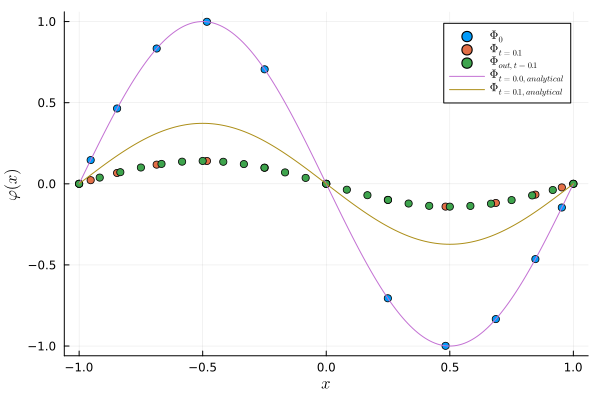

In [176]:
plot(xleg, phi0,seriestype=:scatter,  label=L"\Phi_0",format=:png)
plot!(xleg, phi1,seriestype=:scatter,  label=L"\Phi_{t=0.1}",format=:png)
plot!(xxx, phiout,seriestype=:scatter,  label=L"\Phi_{out,t=0.1}",format=:png)
plot!(xana, phiana0,  label=L"\Phi_{t=0.0,analytical}",format=:png)
plot!(xana, phiana,  label=L"\Phi_{t=0.1,analytical}",format=:png)
xlabel!(L"x")
ylabel!(L"\varphi(x)")

Again, looks great!

# 4.7 The Nodal Discontinuous Galerkin Method

Advection equation:

\begin{align}
    &\partial_t\varphi + \partial_x \varphi = 0 , && &-1<x<1 \\
    &\varphi(x,0) = \varphi_0(x) , && &-1\leq x \geq 1 \\
    &\varphi(-1,t) = g(t) , && &t>0
\tag{4.83}
\end{align}

Using the collocation method, the advection equation is: 

\begin{align}
    &\partial_t \Phi + \left( D \mathbf{\Phi} \right)_j = 0 , && j=1,....,N, \\
    &\Phi_0 = g(t)
\tag{4.84}
\end{align}

Where $D$ is the derivative matrix computed via Algorithm 37

Re-writing in the weak form:

\begin{align}
    \left(\varphi_t , \phi \right) + \left(\varphi_x , \phi \right) = 0
\tag{4.127}
\end{align}

for an $\phi$.

Unlike the continuous Galerkin approximation of the previous section, we will not require φ to satisfy the boundary condition on the left. This is what distinguishes the discontinuous from the continuous formulation.
Since we are developing a nodal method, we approximate the solution by a polnomial of degree N and represent the polynomial in the nodal, Lagrange for:

\begin{align}
    \varphi(x,t) \approx \Phi(x,t) = \sum_{j=0}^N \Phi_j(t) l_j(x)
\tag{4.128}
\end{align}

We defer the question of what points to use as the nodes until we have derived the final weak form of the equation that the approximation will satisfy.m

Through lots of math, we choose the Guass Nodes and get:

\begin{align}
    \dot{\Phi}_j = - \left[ \Phi(1,t) \frac{l_j(1)}{w_j} -g(t)\frac{l_j(-1)}{w_j} + \sum_{n=0}^{N} \hat{D}_{j,n} \Phi_n \right] , \:\:\:\:\:\:\:\:\: j = 0,1,....,N
\tag{4.138}
\end{align}

where

\begin{align}
    \hat{D}_{j,n} = -\frac{D_{j,n} w_n}{w_j}
\tag{4.139}
\end{align}

and $D_{n,j} = l_j'(x_n)$ is the transpose of the standard polynomial derivative matrix

We find the boundary value of the solution we need from the interpolant:

\begin{align}
    \Phi(1,t) = \sum_{j=0}^{N} \Phi_j l_j(1)
\tag{4.140}
\end{align}

## 4.7.1 How to Implement

The book's pseudocode is based on an object oriented programming language. Since Julia doesn't have classes we just write functions to construct the necessary variables 

In [179]:
#skip alg 58
#alg 59
#ch 4.7.1 pg 139
#Julia function to create necessary variables
function NodalDiscontinuousGalerkinConstruct(N::Int64, x::Array{Float64}, w::Array{Float64})
    #Inputs
    #N - Number of nodes from 0 to N
    #x - positions of nodes (0 to N) in [-1,1]
    #w - Gauss-Legendre Weights of nodes x
    
    #barycentric weights
    wb = BarycentricWeights(x)
    #interpolation coefficients for l_j(+-1)
    ln1 = LagrangeInterpolatingPolynomials(-1.0, x, wb,1.0e-12)
    lp1 = LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    D = PolynomialDerivativeMatrix(x)
    Dhat = zeros(Float64, (N+1,N+1))
    Dhattotal = zeros(Float64, (N+1,N+1))

    for j in 0:N
        jj=j+1
        for i in 0:N
            ii = i+1 
            Dhat[ii,jj] = -D[jj,ii]*w[jj]/w[ii]
            #total Dhat with transpose
            Dhattotal[jj,ii] = -(lp1[ii]*lp1[jj]  - D[ii,jj]*w[ii])/w[jj]
            #total Dhat without transpose
            # Dhattotal[ii,jj] = -(lp1[ii]*lp1[jj] - D[ii,jj]*w[jj]/w[ii])
        end
    end

    return wb, ln1, lp1, D, Dhat, Dhattotal

end

NodalDiscontinuousGalerkinConstruct (generic function with 1 method)

Below is the code used to obtain the total **Time Derivative** Matrix for stability Analysis by Dr. Kopriva himself. 

<code>
CASE( DG )
  CALL GaussLegendreNodesAndWeights( N, nodes, weights )
  CALL PolynomialDerivativeMatrix( N, nodes, derivativeMatrix )
  ALLOCATE( M(0:N,0:N) )
  ALLOCATE( x(0:N), Ax(0:N) )
  DO j = 0, N
     L_j = LagrangeInterpolatingPolynomial( j, 1.0_RP, N, nodes )
     DO i = 0, N
        L_i = LagrangeInterpolatingPolynomial( i, 1.0_RP, N, nodes )
        M(i,j) = -( L_i*L_j - weights(j)*derivativeMatrix(i,j) )/weights(i)
     END DO
  END DO
  p = 2
CASE( DGL )
  CALL LegendreLobattoNodesAndWeights( N, nodes, weights )
  CALL PolynomialDerivativeMatrix( N, nodes, derivativeMatrix )
  ALLOCATE( M(0:N,0:N) )
  ALLOCATE( x(0:N), Ax(0:N) )
  M = 0.0_RP
  DO j = 0, N
     DO i = 0, N
        M(i,j) = -weights(j)*derivativeMatrix(i,j)/weights(i)
     END DO
  END DO
  DO i = 0, N
     L_i = LagrangeInterpolatingPolynomial( i, 1.0_RP, N, nodes )
     M(i,N) = M(i,N) + L_i/weights(i)
  END DO
  M = -M
</code>

In [180]:
#Alg 60 
#ch 4.7.1 pg 139
#First spatial derivative via Galerkin Approximation
function ComputeDGDerivative(Phi::Array{Float64}, w::Array{Float64}, phiL::Float64, phiR::Float64, Dhat::Array{Float64}, Lp::Array{Float64}, Ln::Array{Float64})

    NN = length(Phi)-1
    dPhi = Dhat*Phi
    
    for j in 0:NN
        jj=j+1
        dPhi[jj] = dPhi[jj] + (phiR * Lp[jj] - phiL * Ln[jj])/w[jj]
        # dPhi[jj] = dPhi[jj] + (phiR * Lp[jj] - phiL * Ln[jj])/w[jj]
    end

    return dPhi
end

ComputeDGDerivative (generic function with 1 method)

In [181]:
#alg 61a
#ch 4.7.1 pg 140
#Interpolation to Boundary for Gauss nodes
function InterpolateToBoundary(Phi::Array{Float64}, Lj::Array{Float64})

    interpolatedValue = 0.0

    for j in 0:N
        jj=j+1
        interpolatedValue = interpolatedValue + Phi[jj]*Lj[jj]
    end

    return interpolatedValue
end
#alg 61
#ch 4.7.1 pg 140
#Time derivative via Discontinuous Galerkin Approximation
function DGTimeDerivative(Phi::Array{Float64},w::Array{Float64}, Dhat::Array{Float64},gt::Float64, Lp::Array{Float64}, Ln::Array{Float64},t::Float64, c::Float64)

    Phil = 0.0
    Phir = 0.0

    if c>0.0
        Phil = gt
        #Phir = InterpolateToBoundary(Phi, Lp)
        Phir = dot(Phi,Lp)
    else
        Phir = gt
        Phil = dot(Phi,Ln)#InterpolateToBoundary(Phi, Ln)
    end
    

    dPhi = ComputeDGDerivative(Phi, w, Phil, Phir, Dhat, Lp, Ln)
    @. dPhi =  -c*dPhi

    return dPhi
    
end

DGTimeDerivative (generic function with 1 method)

In [182]:
#alg 62
#ch 4.7.1 pg 141
#Low Storage RK3 for Nodal Discontinuous Galerkin Method
function DGStepByRK3!(Phi::Array{Float64}, w::Array{Float64}, Dhat::Array{Float64},g::Function, Lp::Array{Float64}, Ln::Array{Float64}, tn::Float64, dt::Float64, c::Float64)

    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    N = length(Phi)
    #Phij = copy(Phi)
    DPhi = zeros(Float64, size(Phi))
    G = zeros(Float64, size(Phi))

    for m in 1:3
        t = tn +bm[m]*dt #update time
        gt = g(t) #boundary condition in time
        #time derivative
        DPhi = DGTimeDerivative(Phi,w, Dhat,gt, Lp, Ln,t, c)#D2*Phi
        @. G = am[m]*G + DPhi
        @. Phi = Phi + gm[m] *dt *G
        

    end
    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGStepByRK3! (generic function with 1 method)

We need to modify **Alg 51** driver for the Legendre Nodal Discontinuous Galerkin Method

In [183]:
#alg 51d
function LegendreNodalDiscontinuousGalerkin!(Phi::Array{Float64},x::Array{Float64}, w::Array{Float64}, NT::Int64, dt::Float64, c::Float64, nu::Float64, Nout::Int64, g::Function)

    #dt = Ttot/NT
    N = Int(length(Phi)) - 1
    tn = 0.0
    #D2 = mthOrderPolynomialDerivativeMatrix(2, x)
    #D = CGDerivativeMatrix(N, x, w)
    wb, ln1, lp1, D, Dhat, Dhattotal = NodalDiscontinuousGalerkinConstruct(N, x, w)

    for n in 0:NT-1

        DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
        tn = (n+1)*dt
        
    end

    X = [-1+2*j/Nout for j in 0:Nout]
    #ww = BarycentricWeights(x)
    T = PolynomialInterpolationMatrix(x,X, wb,1.0e-11)
    Phiout = T*Phi

    return X, Phiout
    
end

LegendreNodalDiscontinuousGalerkin! (generic function with 1 method)

### Stability Analysis

Let's do a stability Analysis of the RK3 time derivative

In [184]:
nnn = [30, 31, 32, 33]
evr = Array{Any}(nothing, length(nnn))
evi = Array{Any}(nothing, length(nnn))


for i in 1:length(nnn)
    xleg, wleg = LegendreGaussNodesAndWeights(nnn[i], 10000000, 1e-12)
    #xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 100000, 1.0e-9);
    wb, ln1, lp1, D, Dhat, Dhattotal = NodalDiscontinuousGalerkinConstruct(nnn[i], xleg, wleg);
    Dhh = Dhattotal #[2:end-1, 2:end-1]#transpose(-1.0 .* Dhattotal)
    ev = eigen(Dhh);
    evr[i] = real.(ev.values)
    evi[i] = imag.(ev.values) ;
end

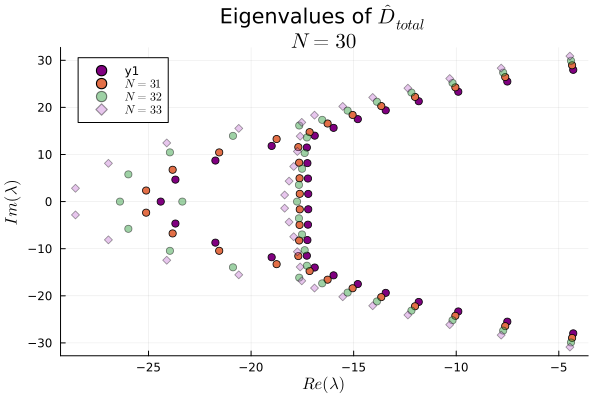

In [185]:
ll =1
plot(evr[ll], evi[ll],seriestype=:scatter,markercolor=:purple,  fmt = :png)
ll = 2
plot!(evr[ll], evi[ll],seriestype=:scatter, label=L"N=31", fmt = :png)
ll = 3
plot!(evr[ll], evi[ll],seriestype=:scatter, label=L"N=32",alpha=0.5, fmt = :png)
ll = 4
plot!(evr[ll], evi[ll],seriestype=:scatter, label=L"N=33",alpha=0.4,markershape=:diamond, fmt = :png)
xlabel!(L"Re(\lambda)")
ylabel!(L"Im(\lambda)")
plot!(title="Eigenvalues of "*L"\hat{D}_{total}"*"\n"*L"N=30")
#plot!(ylimits=(-100,100), xlimits=(-30,0))

##### Maximum Eigenvalues 

Here we obtain the maximum magnitude of eigenvalues ($|\lambda|_{max}$) for different $N$

In [186]:
nnn = [2, 4, 10, 20, 32, 40, 60, 80, 100, 200, 400]
evs = Array{Any}(nothing, length(nnn))


#obtain eigenvalues
for i in 1:length(nnn)
    xleg, wleg = LegendreGaussNodesAndWeights(nnn[i], 10000000, 1e-12)
    #xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 100000, 1.0e-9);
    wb, ln1, lp1, D, Dhat, Dhattotal = NodalDiscontinuousGalerkinConstruct(nnn[i], xleg, wleg);
    Dhh = Dhattotal #[2:end-1, 2:end-1]#transpose(-1.0 .* Dhattotal)
    ev = eigen(Dhh);
    evs[i] = ev.values
end

In [187]:
#take absolute magnitude and find maximum eigenvalue
evmax = Array{Any}(nothing, length(nnn))

for i in 1:length(nnn)
    absevs = abs.(evs[i])
    evmax[i] = log10(maximum(absevs))
    
end

In [188]:
#log10 graph
x11 = [i for i in 1:1000]
y11 = log10.(x11)
#log10 graph with 
x21 = [i for i in 33:1000]
y21 = 1.35.*log10.((x21.-32.0)) ;

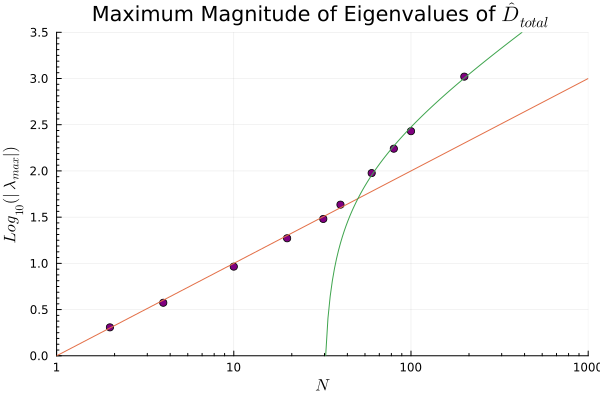

In [189]:

plot(nnn, evmax,seriestype=:scatter,markercolor=:purple, xaxis=:log10, leg=false, xticks=([1,10,100,1000],[1,10,100,1000]),minorticks=8,xlim=(1,1000), ylim=(0,3.5),fmt = :png)
plot!(x11, y11)
plot!(x21, y21)


xlabel!(L"N")
ylabel!(L"Log_{10}(|\lambda_{max}|)")
plot!(title="Maximum Magnitude of Eigenvalues of "*L"\hat{D}_{total}")

##### Stability of RK3 with $\Delta t$

In [190]:
# h = x + iy
#RK3 stability function
R(x,y) = 1 + (x+1.0im*y) +0.5*(x+1.0im*y)^2 +1.0/6.0*(x+1.0im*y)^3 
#real part of h
x = range(-3, 0.5, length=1000);
y = range(-3, 3, length=1000);
r = @. R(x', y);
rr = abs.(r);


Here we get the eigenvalues with different number of nodes $N$

In [191]:
nnn = [8, 16, 32, 64]
evr = Array{Any}(nothing, length(nnn))
evi = Array{Any}(nothing, length(nnn))


for i in 1:length(nnn)
    xleg, wleg = LegendreGaussNodesAndWeights(nnn[i], 10000000, 1e-12)
    #xleg, wleg = LegendreGaussLobattoNodesAndWeights(nn, 100000, 1.0e-9);
    wb, ln1, lp1, D, Dhat, Dhattotal = NodalDiscontinuousGalerkinConstruct(nnn[i], xleg, wleg);
    Dhh = Dhattotal #[2:end-1, 2:end-1]#transpose(-1.0 .* Dhattotal)
    ev = eigen(Dhh);
    evr[i] = real.(ev.values)
    evi[i] = imag.(ev.values) ;
end

Now we multiply the eigenvalues by a $\Delta t$

There is no specific $\Delta t$ so we choose randomly but make sure to be in the range of stability and to get smaller by half with $N^2$

In [192]:
evrdt = Array{Any}(nothing, length(nnn))
evidt = Array{Any}(nothing, length(nnn))

dt = [0.175, 0.043, 0.011, 0.0017]

for i in 1:length(nnn)

    evrdt[i] = @. dt[i] * evr[i]
    evidt[i] = @. dt[i] * evi[i];

end

# evrdt = @. dt * evr
# evidt = @. dt * evi;

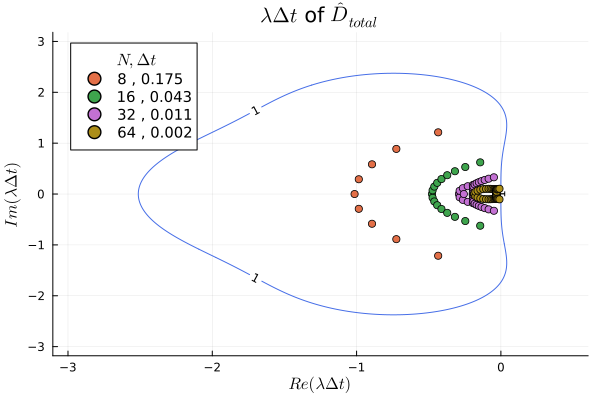

In [193]:
contour(x, y, rr, levels=[1.0], color=:turbo, clabels=true, cbar=false, lw=1, fmt = :png)
plot!(evrdt[1], evidt[1],seriestype=:scatter, fmt = :png, label=string("$(nnn[1]) , ",@sprintf( "%0.3f",dt[1]) ))
plot!(evrdt[2], evidt[2],seriestype=:scatter, fmt = :png, label=string("$(nnn[2]) , ",@sprintf( "%0.3f",dt[2])))
plot!(evrdt[3], evidt[3],seriestype=:scatter, fmt = :png, label=string("$(nnn[3]) , ",@sprintf( "%0.3f",dt[3])))
i=4
plot!(evrdt[i], evidt[i],seriestype=:scatter, fmt = :png, label=string("$(nnn[i]) , ",@sprintf( "%0.3f",dt[i])))
#plot!(title="Chebyshev", legendtitle = L"N , \Delta t")
plot!(title=L"\lambda \Delta t"*" of "*L"\hat{D}_{total}", legendtitle = L"N , \Delta t")
xlabel!(L"Re(\lambda \Delta t)")
ylabel!(L"Im(\lambda \Delta t)")
plot!(legendfontsize=10)

### 4.7.2 Benchmark Solution

Initial conditions at $t=0$: 

\begin{align}
    \varphi_0(x) =  e^{-ln(2) (x+1)^2/\sigma^2}
\end{align}

With: $\sigma = 0.2$

Which means that the full analytical solution for the pulse is:

\begin{align}
    \varphi(x,t) =  e^{-ln(2) (x+1 - t)^2/\sigma^2}
\end{align}

Which gives a group velocity $v_g = 1$ for the pulse. 

Thus at the $x=-1$ boundary, we will have:

\begin{align}
    g(t) =  e^{-ln(2) ( - t)^2/\sigma^2}
\end{align}

In [194]:
PHI(xx, tt) = exp(-log(2.0)*((xx+1) - tt)^2/(sigma)^2)

xana = [i for i in -1:0.01:1];


In [203]:
nn = 32
sigma = 0.2
c = 1.0
dt = 1.0e-3

xleg, wleg = LegendreGaussNodesAndWeights(nn, 100000, 1e-9)

phi0 = @. PHI(xleg,0.0);
phi1 = deepcopy(phi0);
phi2 = deepcopy(phi0);
phi3 = deepcopy(phi0);

nout = 36
#solution at three different times
tout = [0.5, 1.0, 1.5];

phi0ana = @. PHI(xana,0.0);
phi1ana = @. PHI(xana,0.5);
phi2ana = @. PHI(xana,1.0);
phi3ana = @. PHI(xana,1.5);

Here we write our function for $g(t)$

In [196]:
gg(ll) = PHI(-1.0,ll)

gg (generic function with 1 method)

Let's test out our $g(t)$

In [197]:
gg(0.8)

1.5258789062500007e-5

Let's get our solution at 3 different times

In [198]:
ntot = ceil(Int64, tout[1]/dt);

In [199]:
xout1,phiout1 = LegendreNodalDiscontinuousGalerkin!(phi1,xleg, wleg, ntot, dt,c, 1.0, nout, gg);

In [200]:
ntot = ceil(Int64, tout[2]/dt);
xout2,phiout2 = LegendreNodalDiscontinuousGalerkin!(phi2,xleg, wleg, ntot, dt,c, 1.0, nout, gg);

In [201]:
ntot = ceil(Int64, tout[3]/dt);
xout3,phiout3 = LegendreNodalDiscontinuousGalerkin!(phi3,xleg, wleg, ntot, dt, c, 1.0, nout, gg);

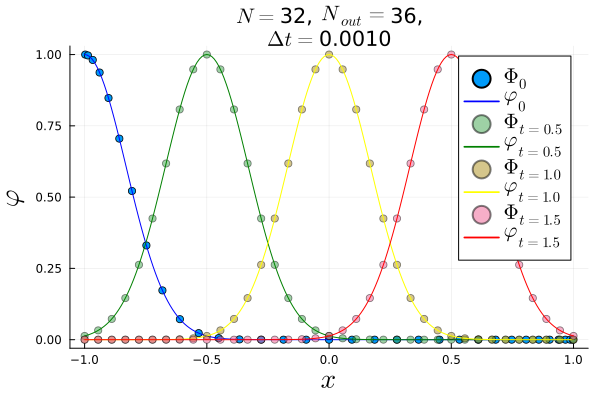

In [202]:
plot(xleg,phi0, seriestype=:scatter,label=L"\Phi_0", format=:png)
plot!(xana, phi0ana, color=:blue,label=L"\varphi_0")
plot!(xout1, phiout1,seriestype=:scatter,markeralpha=0.5,label=latexstring(@sprintf("\\Phi_{t=%.1f}",tout[1])))
plot!(xana, phi1ana, color=:green,label=latexstring(@sprintf("\\varphi_{t=%.1f}",tout[1])))
plot!(xout2, phiout2,seriestype=:scatter,markeralpha=0.5,label=latexstring(@sprintf("\\Phi_{t=%.1f}",tout[2])))
plot!(xana, phi2ana, color=:yellow,label=latexstring(@sprintf("\\varphi_{t=%.1f}",tout[2])))
plot!(xout3, phiout3,seriestype=:scatter,markeralpha=0.5,label=latexstring(@sprintf("\\Phi_{t=%.1f}",tout[3])))
plot!(xana, phi3ana, color=:red,label=latexstring(@sprintf("\\varphi_{t=%.1f}",tout[3])))
plot!(legendfontsize=14)
xlabel!(L"x",xlabelfontsize=18)
ylabel!(L"\varphi", ylabelfontsize=18)
plot!(title=L"N="* string(@sprintf("%d,", nn), L"\:\:\:N_{out} = ", @sprintf("%d,", nout))*"\n"*L"\Delta t = "*@sprintf("%.4f", dt))

# Conclusion

We have finished Chapter 4! This chapter was fast and had a lot of information and skills to be learned. Please review it when necessary because the following notebooks are based of the functions used in Ch 4. 